# Assumptions & Considerations

## Columns

- Quantity, Rate and Total Price columns has informations only when the user purchases.
- Rate is the price per unity of product.
- Total price is the quantity multiplied by the rate. 

## Propensity Models

- They are predictive models to determine the behavior of users based on past behavior. 
- This helps us to create customized campaigns to the users.

1. Data time range - 1 year (2019).
2. Trigger based modelling approach - what is the propensity of buying after a user does the intended action (here it is added to cart). 
3. Only users who added the products to cart are considered in this analysis (ignoring users who made a direct buy because there is no trigger).
4. RFM features are used to improve the performance of the model for the existing users.

# Libraries

In [1]:
import inflection 
import gc 
import re
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import missingno as msno
import sklearn
import seaborn as sns
sns.set()

import warnings 
warnings.filterwarnings('ignore')

from datetime import datetime
from scipy import stats as ss
from pandas_profiling import ProfileReport
from datetime import timedelta
from imblearn import over_sampling as oversamp
from category_encoders import TargetEncoder 
from boruta import BorutaPy
from scikitplot import metrics as mt
from keras import models as ml
from keras import layers as l

from sklearn import preprocessing as pp
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import model_selection as ms
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m

2023-02-05 12:53:31.466402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# Loading Data

In [3]:
data = pd.read_excel('data/final_customer_data.xlsx')
data.head()

,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN


# 1. Data Description

In [4]:
df1 = data.copy()

## Data Fields Meaning

- User_id: unique identifier for each user.

- Session_id: unique identifier that generates every time a user enters the app and it will expire when the user exits the app. 

- DateTime: timestamp when a particular action is performed. 

- Category: product category.

- SubCategory: product sub category. 

- Actions: these are the event, the actions the users can do in the app. These action may be product view, read reviews, purchase, add to cart, etc.

- Quantity: number of products ordered.

- Rate: it is the price per unity of product.

- Total price is the quantity multiplied by the rate.

## 1.1. Rename Columns

We are going to rename columns from camel case to snake case.

In [5]:
df1.columns

Index(['User_id', 'Session_id', 'DateTime', 'Category', 'SubCategory',
       'Action', 'Quantity', 'Rate', 'Total Price'],
      dtype='object')

In [6]:
cols_old = ['User_id', 'Session_id', 'DateTime', 'Category', 'SubCategory',
            'Action', 'Quantity', 'Rate', 'TotalPrice']

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

#rename
df1.columns = cols_new

In [7]:
df1.columns

Index(['user_id', 'session_id', 'date_time', 'category', 'sub_category',
       'action', 'quantity', 'rate', 'total_price'],
      dtype='object')

## 1.2. Data Dimensions

In [8]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 2090
Number of cols: 9


## 1.3. Data Types

In [9]:
df1.dtypes

user_id           int64
session_id       object
date_time        object
category         object
sub_category     object
action           object
quantity        float64
rate            float64
total_price     float64
dtype: object

In [10]:
df1.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN


### 1.3.1. Data conversion

In [11]:
df1["date_time"] = pd.to_datetime(df1["date_time"])
df1.head()

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN


In [12]:
df1.dtypes

user_id                  int64
session_id              object
date_time       datetime64[ns]
category                object
sub_category            object
action                  object
quantity               float64
rate                   float64
total_price            float64
dtype: object

## 1.4. NA Check

In [13]:
df1.isna().sum()

user_id            0
session_id         0
date_time          0
category           0
sub_category       0
action             0
quantity        1889
rate            1889
total_price     1889
dtype: int64

In [14]:
df1.isna().sum()/len(df1)

user_id         0.000000
session_id      0.000000
date_time       0.000000
category        0.000000
sub_category    0.000000
action          0.000000
quantity        0.903828
rate            0.903828
total_price     0.903828
dtype: float64

<AxesSubplot:>

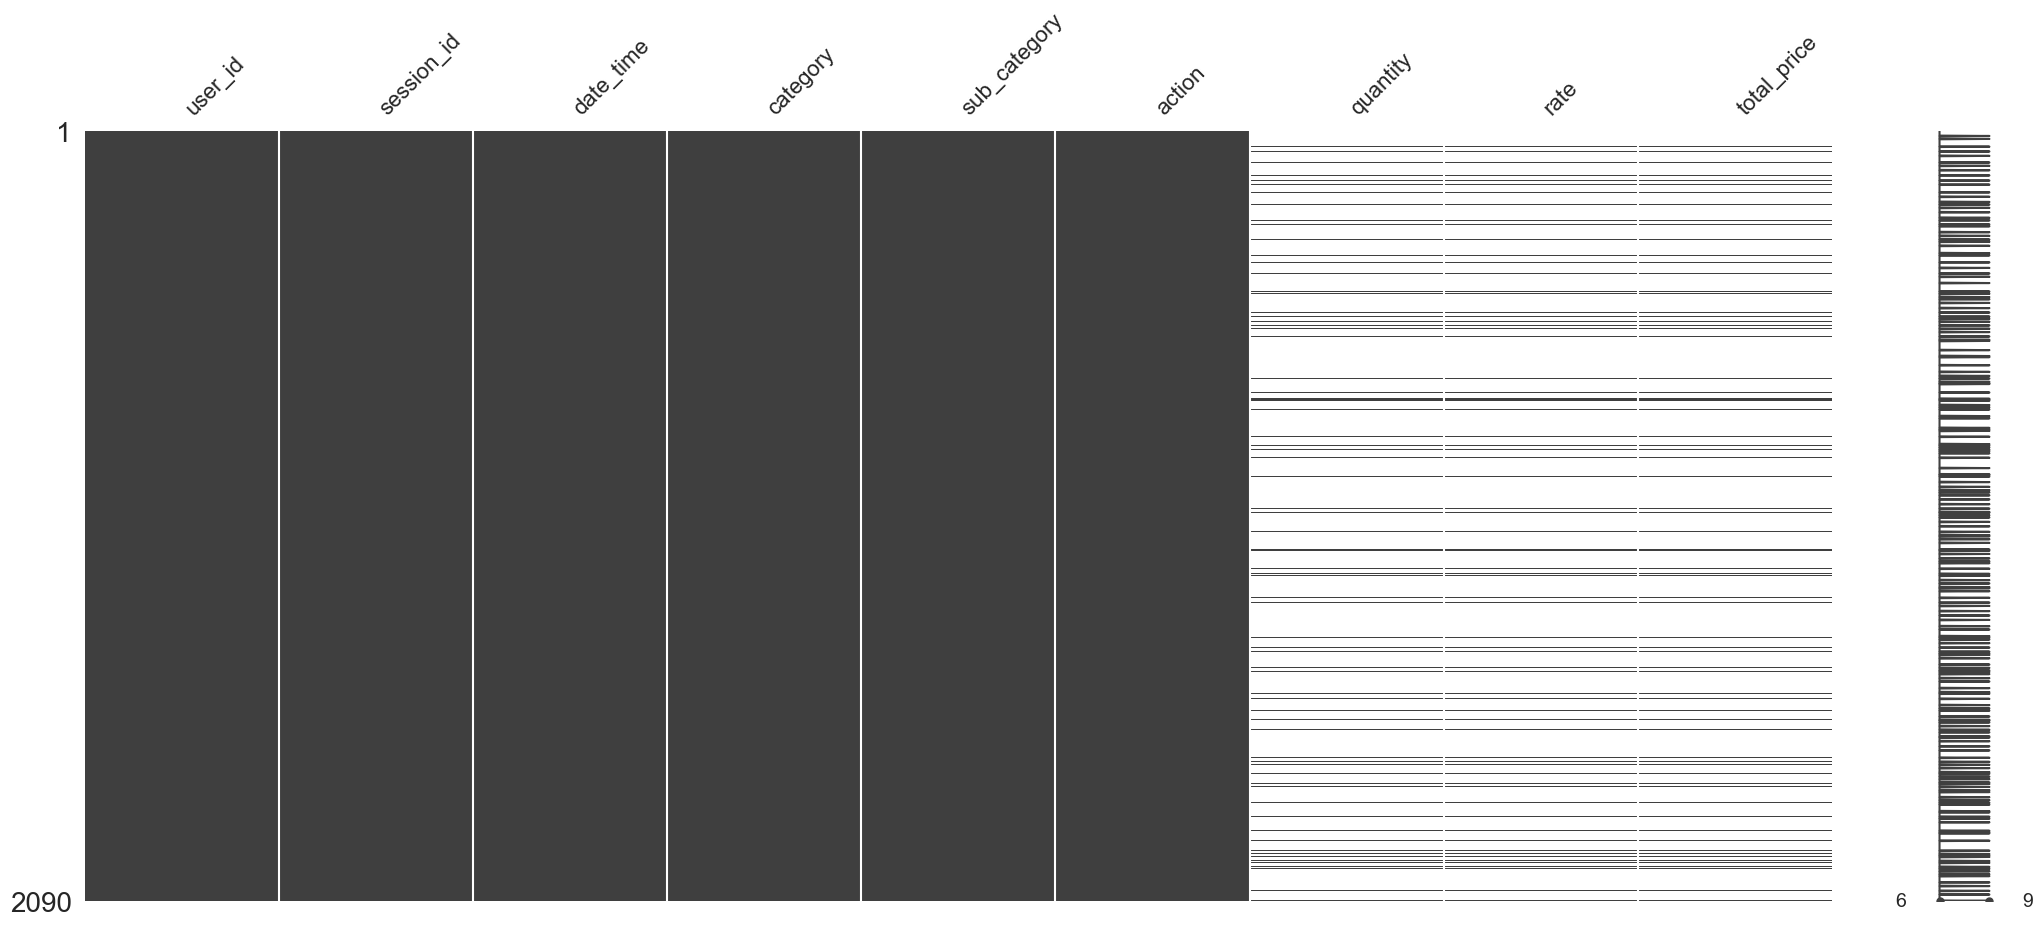

In [15]:
# Visualizing the missing values
msno.matrix(df1)

The white stripes show missing values. The white stripes are equivalent to the row related to the column where the missing value is. 

The missing values are present on the numerical features: quantity, rate and total price. Probably this happens because of no purchase, then the system launchs the information as a missing value.

## 1.5. Removing NA 

As we know, the columns quantity, rate and total price only have informations when the user purchases at least one product. Since these columns have around 90% of NA values, we cannot simply remove those rows. Thus, we are going to assume a value equals zero instead of NA value for this situation.

In [16]:
# quantity
df1['quantity'] = df1['quantity'].fillna(0)

# rate
df1['rate'] = df1['rate'].fillna(0)

# total_price
df1['total_price'] = df1['total_price'].fillna(0)

In [17]:
df1.isna().sum()

user_id         0
session_id      0
date_time       0
category        0
sub_category    0
action          0
quantity        0
rate            0
total_price     0
dtype: int64

## 1.6. Descriptive Statistics

This section is to find inconsistencies, anomalies and also the main characteristics of our data.

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       2090 non-null   int64         
 1   session_id    2090 non-null   object        
 2   date_time     2090 non-null   datetime64[ns]
 3   category      2090 non-null   object        
 4   sub_category  2090 non-null   object        
 5   action        2090 non-null   object        
 6   quantity      2090 non-null   float64       
 7   rate          2090 non-null   float64       
 8   total_price   2090 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 147.1+ KB


In [19]:
df1.describe()

,user_id,quantity,rate,total_price
count,2.090000e+03,2090.000000,2090.000000,2090.000000
mean,5.383871e+10,0.285167,686.023923,909.344498
std,2.781474e+09,2.382323,5033.290983,6287.728594
min,5.144382e+10,0.000000,0.000000,0.000000
25%,5.176871e+10,0.000000,0.000000,0.000000
50%,5.220572e+10,0.000000,0.000000,0.000000
75%,5.566042e+10,0.000000,0.000000,0.000000
max,6.030264e+10,100.000000,90000.000000,160000.000000


In [20]:
num_attributes = df1.drop(columns="user_id").select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.drop(columns="session_id").select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1. Numerical Attributes 

In [21]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,0.0,100.0,100.0,0.285167,0.0,2.381753,35.517850,1471.724892
1,rate,0.0,90000.0,90000.0,686.023923,0.0,5032.086703,11.406039,153.948294
2,total_price,0.0,160000.0,160000.0,909.344498,0.0,6286.224173,13.453022,251.941719


In [22]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df1[df1["quantity"] > 0].drop(columns="user_id").describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,201.00,2.97,7.16,1.00,1.00,2.00,3.00,100.00
rate,201.00,7133.28,14778.15,10.00,500.00,1200.00,6000.00,90000.00
total_price,201.00,9455.37,18213.70,150.00,1000.00,2500.00,8000.00,160000.00


We will use the 75% (75 percentile) as the maximum threshold to avoid outliers.

In [23]:
df1[df1["quantity"] == 100]

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
1484,57767840151,dfxdf936-c74d-4002-a076,2019-10-09 21:53:00,Stationary,Pens,purchase,100.00,10.00,1000.00


In [24]:
df1[df1["rate"] == 90000]

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
1107,53652969521,bb343f67-81be-4b84-9cdb,2019-06-11 15:02:00,Laptop and Desktop,Gaming laptop,purchase,1.00,90000.00,90000.00


In [25]:
df1[df1["total_price"] == 160000]

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
1669,52787855576,fce8cdd0-4572-44df-8e74,2019-11-10 15:07:00,Tablets,iPad,purchase,2.00,80000.00,160000.00


- Standard deviation is too high compared to the mean values. 
- As we have positive values for skew, we have a skewness to the left. Probably due smaller quantities of products purchased and, consequently, smaller values for rate and total price.
- Since quantity has a 1471 value for kurtosis, it has a high peak.
- The maximum values occurred just one time for the three numerical features. Therefore, we may assume they are outliers.

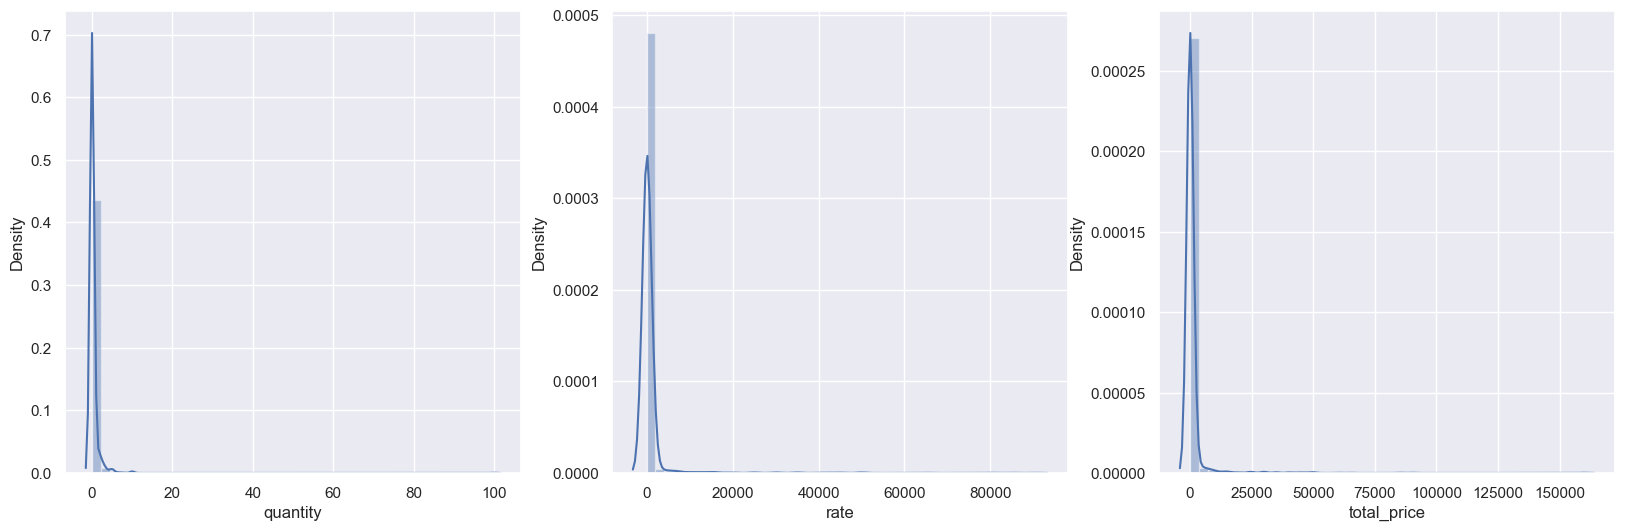

In [26]:
plt.figure(figsize = (20,6))

plt.subplot(131)
sns.distplot(df1["quantity"])

plt.subplot(132)
sns.distplot(df1["rate"])

plt.subplot(133)
sns.distplot(df1["total_price"])

plt.subplots_adjust(wspace = 0.2)

Let's see how the distribution is without the value zero.

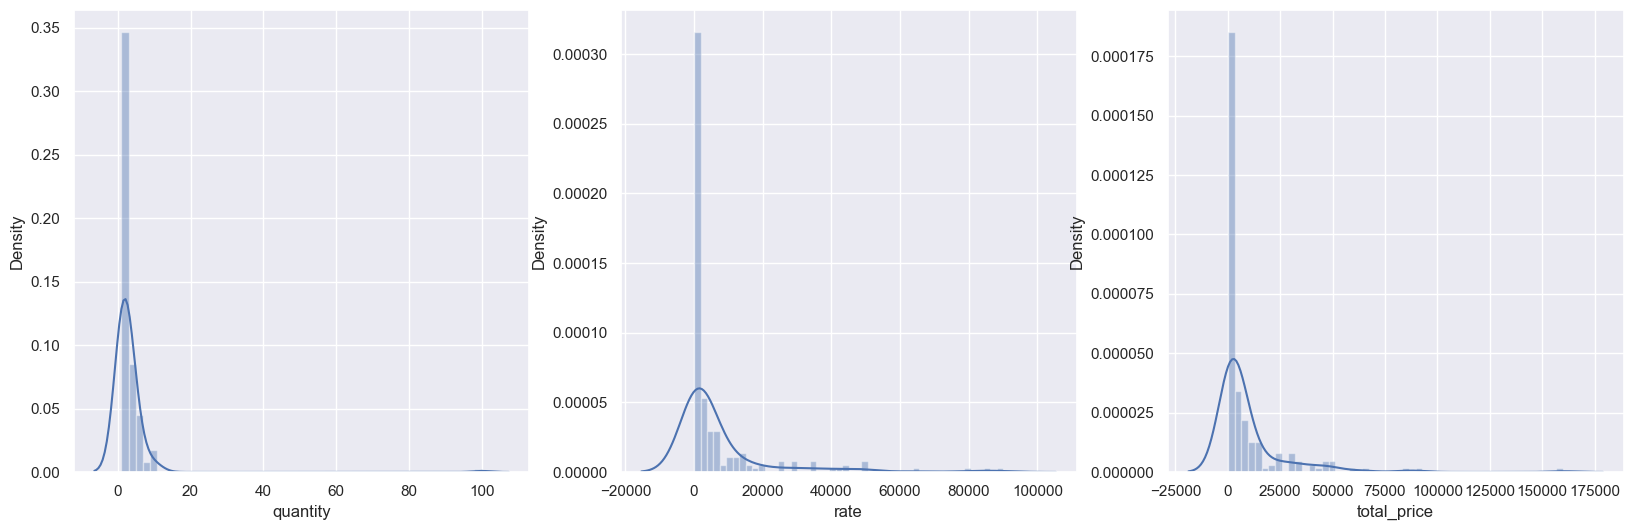

In [27]:
aux = df1[df1["quantity"] != 0]

plt.figure(figsize = (20,6))

plt.subplot(131)
sns.distplot(aux["quantity"])
#plt.xlim(0,)

plt.subplot(132)
sns.distplot(aux["rate"])
#plt.xlim(0,)

plt.subplot(133)
sns.distplot(aux["total_price"])
#plt.xlim(0,)

plt.subplots_adjust(wspace = 0.2)

The majority of purchases is around smaller values for quantity. The result is smaller values for rate and total price too. Let's try to filter the columns again.

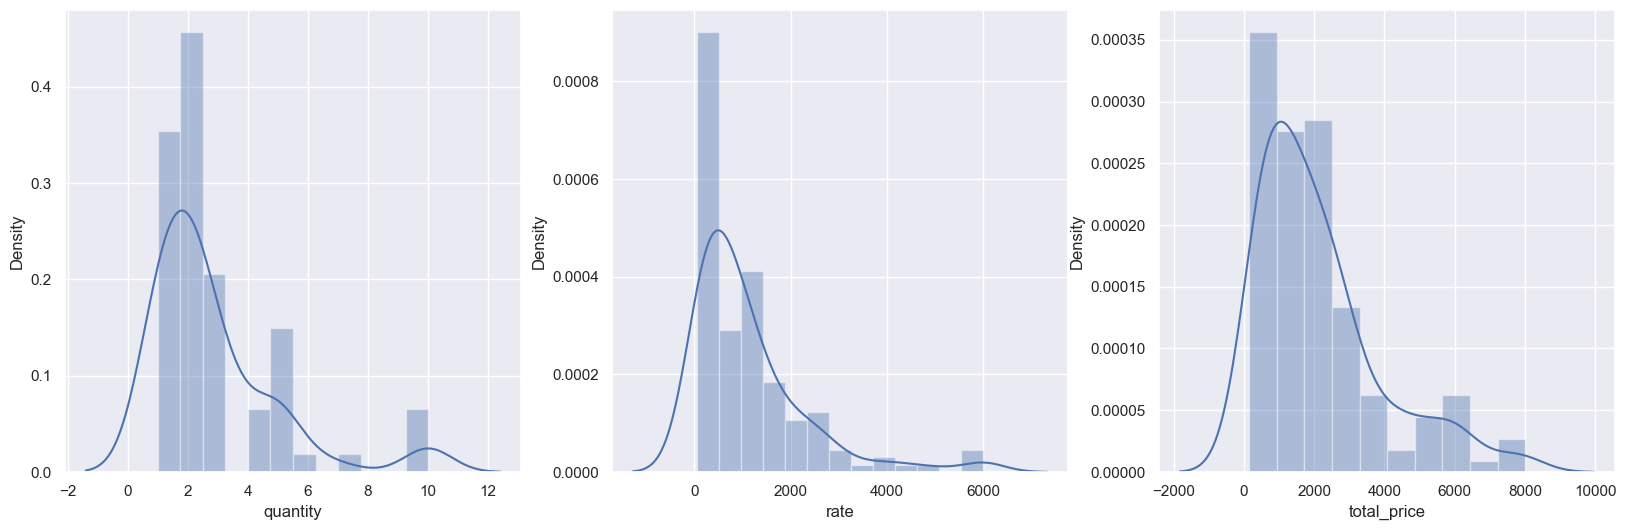

In [28]:
aux = df1[(df1["quantity"] != 0) & (df1["quantity"] < 100) & (df1["rate"] <= 6000) 
          & (df1["total_price"] <= 8000)]

plt.figure(figsize = (20,6))

plt.subplot(131)
sns.distplot(aux["quantity"])
#plt.xlim(0,)

plt.subplot(132)
sns.distplot(aux["rate"])
#plt.xlim(0,)

plt.subplot(133)
sns.distplot(aux["total_price"])
#plt.xlim(0,)

plt.subplots_adjust(wspace = 0.2)

- Now we see a left skew for the three features (positive skewness).
- We see a high kurtosis for quantity.
- We will keep this filter conditions in order to filter outliers rows in the next steps.

### 1.6.2. Categorical Attributes

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

category        105
sub_category    364
action           13
dtype: int64

In [30]:
cat_attributes.apply(lambda x: x.unique())

category        [Electronic Appliances, Men's Fashion, Mobile ...
sub_category    [Speakers, Jeans, Mobile, Cleaning sprays, Cha...
action          [first_app_open, search, product_view, read_re...
dtype: object

In [31]:
cat_attributes["category"].unique()

array(['Electronic Appliances', "Men's Fashion", 'Mobile & Accessories',
       'Cleaning supplies', 'Digital Devices', 'Accessories',
       'Stationary', 'Digital Content', 'Fitness', "Women's Fashion",
       'Household Supplies', 'Smart Wearables', 'Appliances', 'Pet Care',
       'Gardern and Outdoor', 'Camera Accessories', 'eCommerce',
       'Baby Care', 'Gaming Accessories', 'Musical Instruments',
       'Kitchen Appliances', 'Home Appliances', 'Entertainment Systems',
       'Software', 'Pendrives', 'Home Decor', 'Digital Appliances',
       'Electrical tools', 'Large appliances', 'Furnitures',
       'Religious items', 'Artwork', 'Baby Products', 'Car Accessories',
       "Kid's fashion", 'Motorbike Accessories', 'Toys', 'Music',
       'Music\n', 'Gifts', 'Tv and Appliances', 'Bags and Luggage',
       'Large Appliances', 'Industrial', 'Gardening', 'Grocery',
       'Winter Wear', 'Personal Care', "Men's Bottom Wear",
       "Men's Top Wear", 'Shoe care', 'Computer Periphera

In [32]:
cat_attributes["sub_category"].unique()

array(['Speakers', 'Jeans', 'Mobile', 'Cleaning sprays', 'Charging wire',
       'Kindle eBook', 'Watches', 'Cases', 'Books', 'Headphones',
       'Mouse pad', 'Fire Tv', 'Dumbells', 'Ethnic wear', 'Tws earbuds',
       'Cases and Covers', 'Shirts', 'Gloves', 'Dishwasher', 'Bumpers',
       'Denim jeans', 'Smart watches', 'Makeup kit', 'Ropes', 'Printers',
       'Shoes', 'Refrigerators', 'Harddisk', 'Cat food', 'Footwears',
       'Skipping Rope', 'Flower pot', 'Lens', 'Fire TV', 'Oil can',
       'Suspenders', 'Bow tie', 'Paints', 'Ear rings', 'Belt',
       'Frying pan', 'Rice cooker', 'CD-Driver', 'Bangles', 'Powerbells',
       'T-shirt', 'Container', 'Weigh scale', 'Tablet holder', 'Ring',
       'Tops', 'Charger', 'wrist band', 'Delivery bags', 'Women Jacket',
       'Water hose pipe', 'Coolers', 'Baby lotion', 'Aux Cable',
       'USB Cord', 'fitband', 'Screen Guard', 'laptop', 'Web camera',
       'Joystick', 'Tripods', 'Flute', 'Lamp', 'Surround system',
       'Pen stand', '

In [33]:
cat_attributes["action"].unique()

array(['first_app_open', 'search', 'product_view', 'read_reviews',
       'add_review', 'add_to_cart', 'checkout', 'purchase',
       'add_to_wishlist', 'click_wishlist_page', 'product_review',
       'add_to_wishist', 'read_review'], dtype=object)

In [34]:
cat_attributes.describe().T

,count,unique,top,freq
category,2090,105,Mobile & Accessories,139
sub_category,2090,364,Books,46
action,2090,13,read_reviews,342


### 1.6.3. Data Cleaning for Categorical Attributes

We must perform a categorical cleaning, since we have uppercase and words separated by spaces, and special char for the columns category and sub_category.

In [35]:
# category
df1['category'] = df1['category'].apply(lambda x: x.replace(' ', '_').\
                                        replace('\n', '').replace("'s", '').replace("&", "and").lower())

# sub_category
df1['sub_category'] = df1['sub_category'].apply(lambda x: x.replace(' ', '_').\
                                                replace("'s", '').replace("-", '_').lower())     

df1['action'] = df1['action'].apply(lambda x: 'read_reviews' if x in ('read_review') else x)
df1['action'] = df1['action'].apply(lambda x: 'add_to_wishlist' if x in ('add_to_wishist') else x)

In [36]:
df1["category"].unique()

array(['electronic_appliances', 'men_fashion', 'mobile_and_accessories',
       'cleaning_supplies', 'digital_devices', 'accessories',
       'stationary', 'digital_content', 'fitness', 'women_fashion',
       'household_supplies', 'smart_wearables', 'appliances', 'pet_care',
       'gardern_and_outdoor', 'camera_accessories', 'ecommerce',
       'baby_care', 'gaming_accessories', 'musical_instruments',
       'kitchen_appliances', 'home_appliances', 'entertainment_systems',
       'software', 'pendrives', 'home_decor', 'digital_appliances',
       'electrical_tools', 'large_appliances', 'furnitures',
       'religious_items', 'artwork', 'baby_products', 'car_accessories',
       'kid_fashion', 'motorbike_accessories', 'toys', 'music', 'gifts',
       'tv_and_appliances', 'bags_and_luggage', 'industrial', 'gardening',
       'grocery', 'winter_wear', 'personal_care', 'men_bottom_wear',
       'men_top_wear', 'shoe_care', 'computer_peripherals', 'health',
       'laptop_accessories', 'l

In [37]:
df1["sub_category"].unique()

array(['speakers', 'jeans', 'mobile', 'cleaning_sprays', 'charging_wire',
       'kindle_ebook', 'watches', 'cases', 'books', 'headphones',
       'mouse_pad', 'fire_tv', 'dumbells', 'ethnic_wear', 'tws_earbuds',
       'cases_and_covers', 'shirts', 'gloves', 'dishwasher', 'bumpers',
       'denim_jeans', 'smart_watches', 'makeup_kit', 'ropes', 'printers',
       'shoes', 'refrigerators', 'harddisk', 'cat_food', 'footwears',
       'skipping_rope', 'flower_pot', 'lens', 'oil_can', 'suspenders',
       'bow_tie', 'paints', 'ear_rings', 'belt', 'frying_pan',
       'rice_cooker', 'cd_driver', 'bangles', 'powerbells', 't_shirt',
       'container', 'weigh_scale', 'tablet_holder', 'ring', 'tops',
       'charger', 'wrist_band', 'delivery_bags', 'women_jacket',
       'water_hose_pipe', 'coolers', 'baby_lotion', 'aux_cable',
       'usb_cord', 'fitband', 'screen_guard', 'laptop', 'web_camera',
       'joystick', 'tripods', 'flute', 'lamp', 'surround_system',
       'pen_stand', 'mcafee_prot

In [38]:
df1["action"].unique()

array(['first_app_open', 'search', 'product_view', 'read_reviews',
       'add_review', 'add_to_cart', 'checkout', 'purchase',
       'add_to_wishlist', 'click_wishlist_page', 'product_review'],
      dtype=object)

### 1.6.4. Correlation Matrix

Cramer's V method to evaluate correlation between categorical attributes.

In [39]:
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range( len (cat_attributes_list)):
    corr_list = []
    for j in range(len( cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

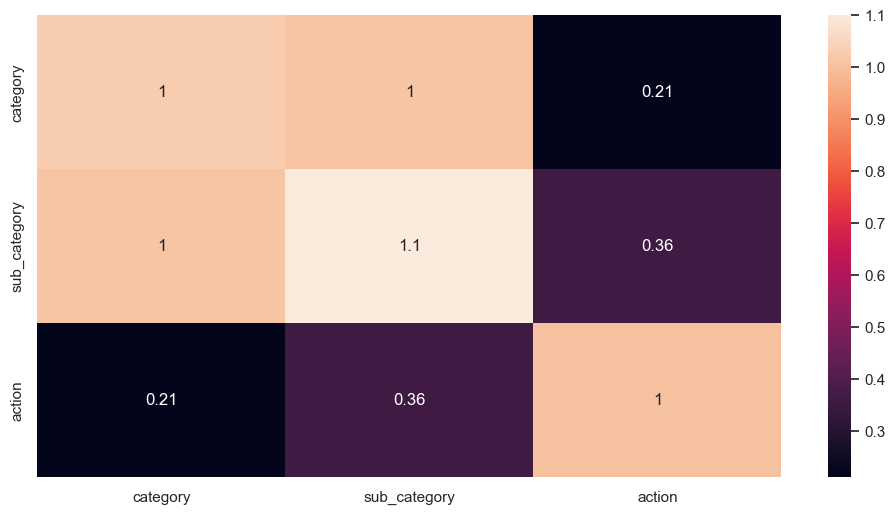

In [40]:
plt.figure(figsize =(12,6))

d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

- The maximum correlation value should be 1. Yet, sub_category is 1.1 correlated with sub_category. Since this happened for the same column, we are just going to consider this value as 1.
- category and sub_category are high correlated. Since we have much more unique values for sub_category (section 1.6.2), we are going to remove category column in the section 3.

# 2. Feature Engineering

In [41]:
df2 = df1.copy()

In [42]:
df2.dtypes

user_id                  int64
session_id              object
date_time       datetime64[ns]
category                object
sub_category            object
action                  object
quantity               float64
rate                   float64
total_price            float64
dtype: object

In [43]:
df2.head()

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,men_fashion,jeans,product_view,0.00,0.00,0.00
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,men_fashion,jeans,read_reviews,0.00,0.00,0.00


## 2.1. Date Features

In [44]:
# year 
df2['year'] = df2['date_time'].dt.year

# month  
df2['month'] = df2['date_time'].dt.month

# day  
df2['day'] = df2['date_time'].dt.day

# day of week  
df2['day_of_week'] = df2['date_time'].dt.dayofweek

# week of year  
df2['week_of_year'] = df2['date_time'].dt.weekofyear

In [45]:
df2.shape

(2090, 14)

## 2.2. User Activity Features

#### Number of days active

In [46]:
# Calculating number of days active
temp_days_active = df2.groupby('user_id').agg({'date_time': 'nunique'}).reset_index()
temp_days_active.rename(columns={'date_time':'number_of_days_active'}, inplace=True)
print(temp_days_active.shape)
temp_days_active.head(3)

(401, 2)


,user_id,number_of_days_active
0,51443820326,3
1,51448162784,12
2,51455512201,10


In [47]:
# Adding days_active
df2 = pd.merge(df2, temp_days_active, on='user_id', how='left')
print(df2.shape)
df2.head(3)

(2090, 15)


,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,2
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,2
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,3


#### Average days between purchase

In [48]:
temp = df2.copy()

temp_user_purchase_date = (temp[temp['action']=='purchase'].sort_values(by='date_time')
                           .groupby('user_id').agg({'date_time': lambda x: list(x)}).reset_index())
temp_user_purchase_date.head()

,user_id,date_time
0,51448162784,"[2019-06-11 13:23:00, 2019-12-12 19:22:00]"
1,51455512201,[2019-10-19 19:12:00]
2,51462598385,"[2019-10-20 17:30:00, 2019-12-15 19:03:00]"
3,51463622150,"[2019-10-14 21:44:00, 2019-11-12 21:27:00]"
4,51465529647,"[2019-12-05 19:30:00, 2019-12-12 21:15:00]"


In [49]:
# Calculating the maximum number of purchase days for each user
x = 0
for i in range(len(temp_user_purchase_date)):
    
    if x < len(temp_user_purchase_date.loc[i, "date_time"]):
        x = len(temp_user_purchase_date.loc[i, "date_time"])
        
    else:
        x = x
        
# Maximum number of purchases days
x

3

In [50]:
# Calculating the difference difference in days between purchases
def purch_time_diff(x):
    if len(x) == 2:
        return (x[1]-x[0]).days

    if len(x) == 3:
        diff_12 = (x[1]-x[0]).days
        diff_23 = (x[2]-x[1]).days
        return (diff_12+diff_23)/2

In [51]:
# Selecting purchase date
temp_user_purchase_date['purchase1'] = temp_user_purchase_date['date_time'].apply(lambda x: x[0])
temp_user_purchase_date['purchase2'] = temp_user_purchase_date['date_time'].apply(lambda x: x[1] if len(x)>1 else 0)
temp_user_purchase_date['purchase3'] = temp_user_purchase_date['date_time'].apply(lambda x: x[2] if len(x)>2 else 0)

temp_user_purchase_date['avg_days_between_purchase'] = temp_user_purchase_date['date_time']\
                                                       .apply(purch_time_diff)

print(temp_user_purchase_date.shape)
temp_user_purchase_date.head()

(167, 6)


,user_id,date_time,purchase1,purchase2,purchase3,avg_days_between_purchase
0,51448162784,"[2019-06-11 13:23:00, 2019-12-12 19:22:00]",2019-06-11 13:23:00,2019-12-12 19:22:00,0,184.00
1,51455512201,[2019-10-19 19:12:00],2019-10-19 19:12:00,0,0,NaN
2,51462598385,"[2019-10-20 17:30:00, 2019-12-15 19:03:00]",2019-10-20 17:30:00,2019-12-15 19:03:00,0,56.00
3,51463622150,"[2019-10-14 21:44:00, 2019-11-12 21:27:00]",2019-10-14 21:44:00,2019-11-12 21:27:00,0,28.00
4,51465529647,"[2019-12-05 19:30:00, 2019-12-12 21:15:00]",2019-12-05 19:30:00,2019-12-12 21:15:00,0,7.00


"gc.collect()" is a function in Python that runs the garbage collector. The garbage collector is responsible for automatically freeing up memory that is no longer being used by the program. By calling "gc.collect()", you can manually force the garbage collector to run, which can be useful in certain situations where you want to free up memory as soon as possible.

In [52]:
gc.collect()

44461

In [53]:
# Adding average time between purchase
df2 = pd.merge(df2, temp_user_purchase_date[['user_id','avg_days_between_purchase']], 
                   on='user_id', how='left')
df2["avg_days_between_purchase"] = df2["avg_days_between_purchase"]
print(df2.shape)
df2.head(3)

(2090, 16)


,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,2,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,2,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,3,NaN


#### Purchase and Cart ratio

In [54]:
temp = df2.copy()

In [55]:
def purchase_ratios(action_col='add_to_cart',id_col='user_id', col_name='number_of_carts'):
    
    # Number of add_to_cart for each user
    test1 = (temp[temp['action']==action_col]
                          .groupby(id_col).agg({'session_id':'count'}).reset_index())
    test1.rename(columns={'session_id': col_name}, inplace=True)
    
    # Number of purchases for each user
    test2 = temp[temp['action']=='purchase'].groupby(id_col).agg({'session_id':'count'}).reset_index()
    test2.rename(columns={'session_id':'number_of_purchases'}, inplace=True)
    
    test_ratio = pd.merge(test1,test2,on=id_col, how='left')
    test_ratio = test_ratio.fillna(0)
    test_ratio[col_name+'_to_purchase_ratio'] = (test_ratio['number_of_purchases']/test_ratio[col_name])
    
    return test_ratio


In [56]:
# purchase and cart ratio
temp_cart_purch_ratio_user = purchase_ratios(action_col='add_to_cart',id_col='user_id',col_name='number_of_carts')

display(temp_cart_purch_ratio_user.head())
temp_cart_purch_ratio_user.describe()

,user_id,number_of_carts,number_of_purchases,number_of_carts_to_purchase_ratio
0,51448162784,2,2.00,1.00
1,51455512201,1,1.00,1.00
2,51462598385,2,2.00,1.00
3,51463622150,2,2.00,1.00
4,51465529647,3,2.00,0.67


,user_id,number_of_carts,number_of_purchases,number_of_carts_to_purchase_ratio
count,240.00,240.00,240.00,240.00
mean,53965915865.43,1.17,0.75,0.61
std,2767010340.70,0.41,0.70,0.53
min,51448162784.00,1.00,0.00,0.00
25%,51857206650.00,1.00,0.00,0.00
50%,52318501056.50,1.00,1.00,1.00
75%,55867444260.00,1.00,1.00,1.00
max,60302643179.00,3.00,3.00,3.00


In [57]:
gc.collect()

0

In [58]:
# Adding carts to purchase ratio
df2 = pd.merge(df2, temp_cart_purch_ratio_user[['user_id','number_of_carts_to_purchase_ratio']], 
                   on='user_id', how='left')
df2["number_of_carts_to_purchase_ratio"] = df2["number_of_carts_to_purchase_ratio"].fillna(0)
df2.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,number_of_carts_to_purchase_ratio
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,2,NaN,0.00
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,2,NaN,0.00
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,3,NaN,0.00


#### Purchase and Whishlist ratio

In [59]:
temp = df2.copy()

In [60]:
# Click wishlist to purchase ratio
temp_click_wishlist_purch_ratio_user = purchase_ratios(action_col='click_wishlist_page',
                                             id_col='user_id', col_name='number_of_click_wishlist')

display(temp_click_wishlist_purch_ratio_user.head())
temp_click_wishlist_purch_ratio_user.describe()

,user_id,number_of_click_wishlist,number_of_purchases,number_of_click_wishlist_to_purchase_ratio
0,51448162784,1,2.00,2.00
1,51463622150,1,2.00,2.00
2,51465529647,1,2.00,2.00
3,51468519074,1,1.00,1.00
4,51475146821,1,0.00,0.00


,user_id,number_of_click_wishlist,number_of_purchases,number_of_click_wishlist_to_purchase_ratio
count,191.00,191.00,191.00,191.00
mean,54038646719.57,1.06,0.49,0.46
std,2800753089.25,0.27,0.69,0.64
min,51448162784.00,1.00,0.00,0.00
25%,51820710836.00,1.00,0.00,0.00
50%,52304977219.00,1.00,0.00,0.00
75%,56185191425.00,1.00,1.00,1.00
max,60302643179.00,3.00,3.00,2.00


In [61]:
# Add wishlist to purchase ratio
temp_add_wishlist_purch_ratio_user = purchase_ratios(action_col='add_to_wishlist',
                                             id_col='user_id',col_name='number_of_add_wishlist')

display(temp_add_wishlist_purch_ratio_user.head())
temp_add_wishlist_purch_ratio_user.describe()

,user_id,number_of_add_wishlist,number_of_purchases,number_of_add_wishlist_to_purchase_ratio
0,51463622150,1,2.00,2.00
1,51477448981,2,1.00,0.50
2,51517997197,2,2.00,1.00
3,51526464449,1,2.00,2.00
4,51565158157,4,3.00,0.75


,user_id,number_of_add_wishlist,number_of_purchases,number_of_add_wishlist_to_purchase_ratio
count,26.00,26.00,26.00,26.00
mean,52954574984.19,1.46,1.54,1.21
std,2529051760.69,0.76,0.71,0.69
min,51463622150.00,1.00,0.00,0.00
25%,51616418156.50,1.00,1.00,0.81
50%,51755725866.50,1.00,2.00,1.00
75%,52300513881.50,2.00,2.00,2.00
max,59533420690.00,4.00,3.00,2.00


In [62]:
gc.collect()

0

In [63]:
# Adding wishlist to purchase ratios (click & add)
df2 = pd.merge(df2, 
                   temp_click_wishlist_purch_ratio_user[['user_id','number_of_click_wishlist_to_purchase_ratio']], 
                   on='user_id', how='left')

df2 = pd.merge(df2, 
                   temp_add_wishlist_purch_ratio_user[['user_id','number_of_add_wishlist_to_purchase_ratio']], 
                   on='user_id', how='left')

df2["number_of_click_wishlist_to_purchase_ratio"] = df2["number_of_click_wishlist_to_purchase_ratio"].fillna(0)
df2["number_of_add_wishlist_to_purchase_ratio"] = df2["number_of_add_wishlist_to_purchase_ratio"].fillna(0)

df2.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,number_of_carts_to_purchase_ratio,number_of_click_wishlist_to_purchase_ratio,number_of_add_wishlist_to_purchase_ratio
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,2,NaN,0.00,0.00,0.00
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,2,NaN,0.00,0.00,0.00
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,3,NaN,0.00,0.00,0.00


#### Path to Cart

In [64]:
temp = df2.copy()

In [65]:
# Filtering the dataset by max add_to_cart date for each user (All users who have done add_to_cart event)
temp = (temp.sort_values(by='date_time')
        [(temp.date_time <= temp.user_id.map(temp[temp['action']=='add_to_cart'].groupby('user_id').date_time.max()))
        ])
print(temp.shape)
print(temp.user_id.nunique())
temp.head(3)

(1192, 19)
240


,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,number_of_carts_to_purchase_ratio,number_of_click_wishlist_to_purchase_ratio,number_of_add_wishlist_to_purchase_ratio
942,51725305614,hfg03b-d558-4953-b218,2019-01-01 11:00:00,men_fashion,shirts,search,0.00,0.00,0.00,2019,1,1,1,1,23,118.00,1.00,1.00,1.00
943,51725305614,cbvg11b4-fadf-4d3c-8834,2019-01-01 11:05:00,men_fashion,shirts,product_view,0.00,0.00,0.00,2019,1,1,1,1,23,118.00,1.00,1.00,1.00
944,51725305614,gcv0ec1-a246-4d24-b94a,2019-01-01 11:10:00,men_fashion,shirts,read_reviews,0.00,0.00,0.00,2019,1,1,1,1,23,118.00,1.00,1.00,1.00


In [66]:
temp_path =  temp.sort_values(by='date_time').groupby('user_id').agg({'action': lambda x: list(x)}).reset_index()
temp_path.head()

,user_id,action
0,51448162784,"[first_app_open, search, product_view, read_re..."
1,51455512201,"[first_app_open, search, product_view, read_re..."
2,51462598385,"[search, product_view, read_reviews, add_to_ca..."
3,51463622150,"[first_app_open, search, read_reviews, search,..."
4,51465529647,"[search, add_to_cart, click_wishlist_page, add..."


The regular expression pattern "last_3_actions" matches strings that contain the words "add_to_cart" preceded by zero to three words separated by a single space.

The regular expression consists of two parts:

((?:\S+\s+){0,3}) matches zero to three sequences of one or more non-whitespace characters followed by a single space. This matches the preceding words, if any.

\badd_to_cart\b matches the word "add_to_cart". The word boundaries \b ensure that only complete words are matched and not just substrings.

The whole expression ((?:\S+\s+){0,3}\badd_to_cart) matches strings that contain the words "add_to_cart" preceded by zero to three words separated by a single space. The parentheses around the expression indicate that the matched text should be captured as a group and can be retrieved using the "re.findall()" function.

In [67]:
last_3_actions = r'((?:\S+\s+){0,3}\badd_to_cart)'

temp_path['action_cleaned'] = temp_path['action'].apply(lambda x: ' '.join(x))
temp_path['last_3_actions'] = temp_path['action_cleaned'].apply(lambda x: re.findall(last_3_actions, x))
temp_path.head()

,user_id,action,action_cleaned,last_3_actions
0,51448162784,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,"[search product_view read_reviews add_to_cart,..."
1,51455512201,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,[search product_view read_reviews add_to_cart]
2,51462598385,"[search, product_view, read_reviews, add_to_ca...",search product_view read_reviews add_to_cart s...,"[search product_view read_reviews add_to_cart,..."
3,51463622150,"[first_app_open, search, read_reviews, search,...",first_app_open search read_reviews search prod...,[purchase search click_wishlist_page add_to_ca...
4,51465529647,"[search, add_to_cart, click_wishlist_page, add...",search add_to_cart click_wishlist_page add_to_...,[search add_to_cart click_wishlist_page add_to...


In [68]:
# Cleaning and selecting the latest path for each user
temp_path['final_3_actions'] = temp_path['last_3_actions'].apply(lambda x: x[0] if len(x)==1 else x)
temp_path['final_3_actions'] = temp_path['final_3_actions'].apply(lambda x: x[1] if len(x)==2 else x)
temp_path['final_3_actions'] = temp_path['final_3_actions'].apply(lambda x: x[2] if len(x)==3 else x)

temp_path.head()

,user_id,action,action_cleaned,last_3_actions,final_3_actions
0,51448162784,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,"[search product_view read_reviews add_to_cart,...",search read_reviews add_to_cart
1,51455512201,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,[search product_view read_reviews add_to_cart],search product_view read_reviews add_to_cart
2,51462598385,"[search, product_view, read_reviews, add_to_ca...",search product_view read_reviews add_to_cart s...,"[search product_view read_reviews add_to_cart,...",search product_view add_to_cart
3,51463622150,"[first_app_open, search, read_reviews, search,...",first_app_open search read_reviews search prod...,[purchase search click_wishlist_page add_to_ca...,search product_view add_to_cart
4,51465529647,"[search, add_to_cart, click_wishlist_page, add...",search add_to_cart click_wishlist_page add_to_...,[search add_to_cart click_wishlist_page add_to...,search add_to_cart


In [69]:
# Cleaning and selecting the latest path for each user
temp_path['final_3_actions'] = temp_path['last_3_actions'].apply(lambda x: x[0] if len(x)==1 else x)
temp_path['final_3_actions'] = temp_path['final_3_actions'].apply(lambda x: x[1] if len(x)==2 else x)
temp_path['final_3_actions'] = temp_path['final_3_actions'].apply(lambda x: x[2] if len(x)==3 else x)

temp_path.head()

,user_id,action,action_cleaned,last_3_actions,final_3_actions
0,51448162784,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,"[search product_view read_reviews add_to_cart,...",search read_reviews add_to_cart
1,51455512201,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,[search product_view read_reviews add_to_cart],search product_view read_reviews add_to_cart
2,51462598385,"[search, product_view, read_reviews, add_to_ca...",search product_view read_reviews add_to_cart s...,"[search product_view read_reviews add_to_cart,...",search product_view add_to_cart
3,51463622150,"[first_app_open, search, read_reviews, search,...",first_app_open search read_reviews search prod...,[purchase search click_wishlist_page add_to_ca...,search product_view add_to_cart
4,51465529647,"[search, add_to_cart, click_wishlist_page, add...",search add_to_cart click_wishlist_page add_to_...,[search add_to_cart click_wishlist_page add_to...,search add_to_cart


In [70]:
temp_path.final_3_actions.value_counts()

product_view read_reviews click_wishlist_page add_to_cart       29
add_to_cart                                                     25
read_reviews click_wishlist_page add_to_cart                    25
click_wishlist_page add_to_cart                                 24
search product_view read_reviews add_to_cart                    21
read_reviews add_to_cart                                        10
product_view read_reviews add_to_cart                           10
read_reviews product_view click_wishlist_page add_to_cart        9
search read_reviews click_wishlist_page add_to_cart              9
search product_view add_to_cart                                  6
search product_view click_wishlist_page add_to_cart              6
product_view click_wishlist_page add_to_cart                     6
search read_reviews add_to_cart                                  5
product_view add_to_cart                                         3
first_app_open search read_reviews add_to_cart                

In [71]:
# Grouping the paths to top 10 and rest as others
top_10_paths = temp_path.final_3_actions.value_counts()[:10].index.to_list()
print(top_10_paths)
temp_path['top_paths'] = temp_path['final_3_actions'].apply(lambda x: x if x in top_10_paths else 'others')
temp_path.head()

['product_view read_reviews click_wishlist_page add_to_cart', 'add_to_cart', 'read_reviews click_wishlist_page add_to_cart', 'click_wishlist_page add_to_cart', 'search product_view read_reviews add_to_cart', 'read_reviews add_to_cart', 'product_view read_reviews add_to_cart', 'read_reviews product_view click_wishlist_page add_to_cart', 'search read_reviews click_wishlist_page add_to_cart', 'search product_view add_to_cart']


,user_id,action,action_cleaned,last_3_actions,final_3_actions,top_paths
0,51448162784,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,"[search product_view read_reviews add_to_cart,...",search read_reviews add_to_cart,others
1,51455512201,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,[search product_view read_reviews add_to_cart],search product_view read_reviews add_to_cart,search product_view read_reviews add_to_cart
2,51462598385,"[search, product_view, read_reviews, add_to_ca...",search product_view read_reviews add_to_cart s...,"[search product_view read_reviews add_to_cart,...",search product_view add_to_cart,search product_view add_to_cart
3,51463622150,"[first_app_open, search, read_reviews, search,...",first_app_open search read_reviews search prod...,[purchase search click_wishlist_page add_to_ca...,search product_view add_to_cart,search product_view add_to_cart
4,51465529647,"[search, add_to_cart, click_wishlist_page, add...",search add_to_cart click_wishlist_page add_to_...,[search add_to_cart click_wishlist_page add_to...,search add_to_cart,others


In [72]:
temp_path.top_paths.value_counts()

others                                                       72
product_view read_reviews click_wishlist_page add_to_cart    29
read_reviews click_wishlist_page add_to_cart                 25
add_to_cart                                                  25
click_wishlist_page add_to_cart                              24
search product_view read_reviews add_to_cart                 21
product_view read_reviews add_to_cart                        10
read_reviews add_to_cart                                     10
search read_reviews click_wishlist_page add_to_cart           9
read_reviews product_view click_wishlist_page add_to_cart     9
search product_view add_to_cart                               6
Name: top_paths, dtype: int64

In [73]:
gc.collect()

0

In [74]:
# Adding top path-to-cart
df2 = pd.merge(df2, temp_path[['user_id','top_paths']], 
                   on='user_id', how='left')

df2["top_paths"] = df2["top_paths"].fillna("Not added to cart")
df2.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,number_of_carts_to_purchase_ratio,number_of_click_wishlist_to_purchase_ratio,number_of_add_wishlist_to_purchase_ratio,top_paths
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,2,NaN,0.00,0.00,0.00,Not added to cart
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,2,NaN,0.00,0.00,0.00,Not added to cart
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,3,NaN,0.00,0.00,0.00,Not added to cart


## 2.3. Category/Subcategory-level Features

#### Purchase and Cart Ratio

In [75]:
temp = df2.copy()
temp.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,number_of_carts_to_purchase_ratio,number_of_click_wishlist_to_purchase_ratio,number_of_add_wishlist_to_purchase_ratio,top_paths
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,2,NaN,0.00,0.00,0.00,Not added to cart
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,2,NaN,0.00,0.00,0.00,Not added to cart
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,3,NaN,0.00,0.00,0.00,Not added to cart


In [76]:
# Category level - cart_to_purchase_ratio
temp_cart_purch_ratio_category = purchase_ratios(action_col='add_to_cart',
                                                 id_col='category', col_name='category_number_of_carts')
display(temp_cart_purch_ratio_category.head())
temp_cart_purch_ratio_category.describe()

,category,category_number_of_carts,number_of_purchases,category_number_of_carts_to_purchase_ratio
0,accessories,15,12.00,0.80
1,air_conditioner,1,2.00,2.00
2,appliances,1,1.00,1.00
3,artwork,1,0.00,0.00
4,audio,1,0.00,0.00


,category_number_of_carts,number_of_purchases,category_number_of_carts_to_purchase_ratio
count,87.00,87.00,87.00
mean,3.22,2.28,0.74
std,3.69,2.85,0.57
min,1.00,0.00,0.00
25%,1.00,1.00,0.33
50%,2.00,1.00,0.75
75%,3.00,2.50,1.00
max,17.00,14.00,3.00


In [77]:
# Subcategory level - cart_to_purchase_ratio
temp_cart_purch_ratio_subcategory = (purchase_ratios(action_col='add_to_cart',
                                                     id_col='sub_category', col_name='subcategory_number_of_carts'))
display(temp_cart_purch_ratio_subcategory.head())
temp_cart_purch_ratio_subcategory.describe()

,sub_category,subcategory_number_of_carts,number_of_purchases,subcategory_number_of_carts_to_purchase_ratio
0,air_coolers,1,1.00,1.00
1,air_tight_container,1,0.00,0.00
2,amazon_alexa,1,0.00,0.00
3,amplifier,1,1.00,1.00
4,audio_speakers,1,0.00,0.00


,subcategory_number_of_carts,number_of_purchases,subcategory_number_of_carts_to_purchase_ratio
count,237.00,237.00,237.00
mean,1.18,0.78,0.65
std,0.66,0.72,0.50
min,1.00,0.00,0.00
25%,1.00,0.00,0.00
50%,1.00,1.00,1.00
75%,1.00,1.00,1.00
max,8.00,4.00,2.00


In [78]:
gc.collect()

0

In [79]:
# Adding Category & SubCategory level carts-to-purchase ratio
df2 = pd.merge(df2, temp_cart_purch_ratio_category[['category','category_number_of_carts_to_purchase_ratio']], 
                   on='category', how='left')

df2 = pd.merge(df2,
                   temp_cart_purch_ratio_subcategory[['sub_category','subcategory_number_of_carts_to_purchase_ratio']], 
                   on='sub_category', how='left')

df2.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,...,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,number_of_carts_to_purchase_ratio,number_of_click_wishlist_to_purchase_ratio,number_of_add_wishlist_to_purchase_ratio,top_paths,category_number_of_carts_to_purchase_ratio,subcategory_number_of_carts_to_purchase_ratio
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,...,3,2,2,NaN,0.00,0.00,0.00,Not added to cart,0.67,0.50
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,...,3,2,2,NaN,0.00,0.00,0.00,Not added to cart,0.67,0.50
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,...,3,2,3,NaN,0.00,0.00,0.00,Not added to cart,0.80,1.50


#### Purchase and Wishlist ratio

In [80]:
temp = df2.copy()

In [81]:
# Category level - click_wishlist_to_purchase_ratio
temp_click_wishlist_purch_ratio_category = (purchase_ratios(action_col='click_wishlist_page',
                                                    id_col='category',col_name='category_number_of_click_wishlist'))
display(temp_click_wishlist_purch_ratio_category.head())
temp_click_wishlist_purch_ratio_category.describe()

,category,category_number_of_click_wishlist,number_of_purchases,category_number_of_click_wishlist_to_purchase_ratio
0,accessories,14,12.00,0.86
1,appliances,3,1.00,0.33
2,artwork,1,0.00,0.00
3,audio,1,0.00,0.00
4,baby_care,4,1.00,0.25


,category_number_of_click_wishlist,number_of_purchases,category_number_of_click_wishlist_to_purchase_ratio
count,71.00,71.00,71.00
mean,2.85,2.46,0.89
std,2.59,3.11,0.83
min,1.00,0.00,0.00
25%,1.00,1.00,0.25
50%,2.00,1.00,0.75
75%,4.00,3.00,1.47
max,14.00,14.00,4.00


In [82]:
# SubCategory level - click_wishlist_to_purchase_ratio
temp_click_wishlist_purch_ratio_subcategory = (purchase_ratios(action_col='click_wishlist_page',
                                                    id_col='sub_category',col_name='subcategory_number_of_click_wishlist'))
display(temp_click_wishlist_purch_ratio_subcategory.head())
temp_click_wishlist_purch_ratio_subcategory.describe()

,sub_category,subcategory_number_of_click_wishlist,number_of_purchases,subcategory_number_of_click_wishlist_to_purchase_ratio
0,air_coolers,1,1.00,1.00
1,air_tight_container,1,0.00,0.00
2,amazon_alexa,1,0.00,0.00
3,audio_speakers,1,0.00,0.00
4,baby_care_set,1,0.00,0.00


,subcategory_number_of_click_wishlist,number_of_purchases,subcategory_number_of_click_wishlist_to_purchase_ratio
count,175.00,175.00,175.00
mean,1.15,0.53,0.46
std,0.58,0.73,0.61
min,1.00,0.00,0.00
25%,1.00,0.00,0.00
50%,1.00,0.00,0.00
75%,1.00,1.00,1.00
max,6.00,4.00,4.00


In [83]:
# Category level - add_wishlist_to_purchase_ratio
temp_add_wishlist_purch_ratio_category = (purchase_ratios(action_col='add_to_wishlist',
                                                        id_col='category',col_name='category_number_of_add_wishlist'))
display(temp_add_wishlist_purch_ratio_category.head())
temp_add_wishlist_purch_ratio_category.describe()

,category,category_number_of_add_wishlist,number_of_purchases,category_number_of_add_wishlist_to_purchase_ratio
0,accessories,3,12,4.00
1,baby_care,1,1,1.00
2,bed_room,1,5,5.00
3,digital_appliances,1,2,2.00
4,digital_devices,5,7,1.40


,category_number_of_add_wishlist,number_of_purchases,category_number_of_add_wishlist_to_purchase_ratio
count,17.00,17.00,17.00
mean,2.24,5.65,2.98
std,1.92,4.47,2.43
min,1.00,1.00,1.00
25%,1.00,2.00,1.00
50%,1.00,5.00,2.00
75%,2.00,9.00,4.00
max,7.00,14.00,9.00


In [84]:
# SubCategory level - add_wishlist_to_purchase_ratio
temp_add_wishlist_purch_ratio_subcategory = (purchase_ratios(action_col='add_to_wishlist',
                                                    id_col='sub_category',col_name='subcategory_number_of_add_wishlist'))
display(temp_add_wishlist_purch_ratio_subcategory.head())
temp_add_wishlist_purch_ratio_subcategory.describe()

,sub_category,subcategory_number_of_add_wishlist,number_of_purchases,subcategory_number_of_add_wishlist_to_purchase_ratio
0,books,2,4,2.00
1,bp_monitors,1,1,1.00
2,bumpers,1,1,1.00
3,cases,3,2,0.67
4,charging_wire,1,3,3.00


,subcategory_number_of_add_wishlist,number_of_purchases,subcategory_number_of_add_wishlist_to_purchase_ratio
count,26.00,26.00,26.00
mean,1.46,1.58,1.21
std,0.71,1.06,0.86
min,1.00,1.00,0.33
25%,1.00,1.00,1.00
50%,1.00,1.00,1.00
75%,2.00,1.75,1.00
max,3.00,4.00,4.00


In [85]:
gc.collect()

0

In [86]:
# Adding Category & SubCategory level wishlist-to-purchase ratio (click & add)
df2 = pd.merge(df2, 
                   temp_click_wishlist_purch_ratio_category[['category',
                                                             'category_number_of_click_wishlist_to_purchase_ratio']], 
                   on='category', how='left')

df2 = pd.merge(df2,
                   temp_click_wishlist_purch_ratio_subcategory[['sub_category',
                                                                'subcategory_number_of_click_wishlist_to_purchase_ratio']], 
                   on='sub_category', how='left')

df2 = pd.merge(df2, 
                   temp_add_wishlist_purch_ratio_category[['category',
                                                           'category_number_of_add_wishlist_to_purchase_ratio']], 
                   on='category', how='left')

df2 = pd.merge(df2,
                   temp_add_wishlist_purch_ratio_subcategory[['sub_category',
                                                              'subcategory_number_of_add_wishlist_to_purchase_ratio']], 
                   on='sub_category', how='left')

df2.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,...,number_of_carts_to_purchase_ratio,number_of_click_wishlist_to_purchase_ratio,number_of_add_wishlist_to_purchase_ratio,top_paths,category_number_of_carts_to_purchase_ratio,subcategory_number_of_carts_to_purchase_ratio,category_number_of_click_wishlist_to_purchase_ratio,subcategory_number_of_click_wishlist_to_purchase_ratio,category_number_of_add_wishlist_to_purchase_ratio,subcategory_number_of_add_wishlist_to_purchase_ratio
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,...,0.00,0.00,0.00,Not added to cart,0.67,0.50,0.67,1.00,1.00,0.50
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,...,0.00,0.00,0.00,Not added to cart,0.67,0.50,0.67,1.00,1.00,0.50
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,...,0.00,0.00,0.00,Not added to cart,0.80,1.50,2.00,3.00,8.00,3.00


#### Purchase and Product View ratio

In [87]:
temp = df2.copy()

In [88]:
# Category level - produc_view_wishlist_to_purchase_ratio
temp_product_view_purch_ratio_category = (purchase_ratios(action_col='product_view',
                                                        id_col='category', col_name='category_number_of_product_view'))
display(temp_product_view_purch_ratio_category.head())
temp_product_view_purch_ratio_category.describe()

,category,category_number_of_product_view,number_of_purchases,category_number_of_product_view_to_purchase_ratio
0,accessories,9,12.00,1.33
1,air_conditioner,7,2.00,0.29
2,artwork,1,0.00,0.00
3,audio,1,0.00,0.00
4,baby_care,3,1.00,0.33


,category_number_of_product_view,number_of_purchases,category_number_of_product_view_to_purchase_ratio
count,89.00,89.00,89.00
mean,3.28,2.11,0.62
std,3.70,2.89,0.65
min,1.00,0.00,0.00
25%,1.00,0.00,0.00
50%,2.00,1.00,0.50
75%,4.00,2.00,1.00
max,26.00,14.00,3.00


In [89]:
# SubCategory level - produc_view_wishlist_to_purchase_ratio
temp_product_view_purch_ratio_subcategory = (purchase_ratios(action_col='product_view',
                                                    id_col='sub_category',col_name='subcategory_number_of_product_view'))
display(temp_product_view_purch_ratio_subcategory.head())
temp_product_view_purch_ratio_subcategory.describe()

,sub_category,subcategory_number_of_product_view,number_of_purchases,subcategory_number_of_product_view_to_purchase_ratio
0,amazon_alexa,1,0.00,0.00
1,arm_sleeve,1,0.00,0.00
2,aux_cable,3,1.00,0.33
3,baby_lotion,2,0.00,0.00
4,baby_shampoo,1,0.00,0.00


,subcategory_number_of_product_view,number_of_purchases,subcategory_number_of_product_view_to_purchase_ratio
count,213.00,213.00,213.00
mean,1.37,0.51,0.32
std,0.89,0.77,0.43
min,1.00,0.00,0.00
25%,1.00,0.00,0.00
50%,1.00,0.00,0.00
75%,1.00,1.00,0.67
max,7.00,4.00,1.50


In [90]:
# Adding Category & SubCategory level product_view-to-purchase ratio (click & add)
df2 = pd.merge(df2, 
                   temp_product_view_purch_ratio_category[['category',
                                                           'category_number_of_product_view_to_purchase_ratio']], 
                   on='category', how='left')

df2 = pd.merge(df2,
                   temp_product_view_purch_ratio_subcategory[['sub_category',
                                                              'subcategory_number_of_product_view_to_purchase_ratio']], 
                   on='sub_category', how='left')

df2.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,...,number_of_add_wishlist_to_purchase_ratio,top_paths,category_number_of_carts_to_purchase_ratio,subcategory_number_of_carts_to_purchase_ratio,category_number_of_click_wishlist_to_purchase_ratio,subcategory_number_of_click_wishlist_to_purchase_ratio,category_number_of_add_wishlist_to_purchase_ratio,subcategory_number_of_add_wishlist_to_purchase_ratio,category_number_of_product_view_to_purchase_ratio,subcategory_number_of_product_view_to_purchase_ratio
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,...,0.00,Not added to cart,0.67,0.50,0.67,1.00,1.00,0.50,0.33,0.25
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,...,0.00,Not added to cart,0.67,0.50,0.67,1.00,1.00,0.50,0.33,0.25
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,...,0.00,Not added to cart,0.80,1.50,2.00,3.00,8.00,3.00,0.62,0.43


## 2.4. Target 

Target group of people are those who added items to the cart (Trigger point).

In [91]:
df_tar = (df2[df2['action']=='add_to_cart']
              .groupby('user_id').agg({'category':'max','sub_category':'max'}).reset_index())
df_tar.head()

,user_id,category,sub_category
0,51448162784,camera_accessories,camera_lens
1,51455512201,men_fashion,shoes
2,51462598385,mobile_and_accessories,usb_cord
3,51463622150,stationary,paints
4,51465529647,home_decor,wall_hangings


In [92]:
# Adding the target variable
# Filtering the dataset by max purchase date for each user (All users who have done add_to_cart event)

temp = (df2.sort_values(by='date_time')
        [(df2.date_time == df2.user_id.map(df2[df2['action']=='purchase'].groupby('user_id').date_time.max()))]
       )

purchase_users = temp[temp['action']=='purchase'].groupby('user_id')['action'].count().reset_index()
display(purchase_users.head(3))

,user_id,action
0,51448162784,1
1,51455512201,1
2,51462598385,1


In [93]:
df_tar = pd.merge(df_tar, purchase_users, on='user_id', how='left')
df_tar.head(3)

,user_id,category,sub_category,action
0,51448162784,camera_accessories,camera_lens,1.00
1,51455512201,men_fashion,shoes,1.00
2,51462598385,mobile_and_accessories,usb_cord,1.00


In [94]:
df_tar['action'] = df_tar['action'].fillna(0)
df_tar.rename(columns={'action':'target'}, inplace=True)
df_tar.head(3)

,user_id,category,sub_category,target
0,51448162784,camera_accessories,camera_lens,1.00
1,51455512201,men_fashion,shoes,1.00
2,51462598385,mobile_and_accessories,usb_cord,1.00


In [95]:
df2 = pd.merge(df2,
                   df_tar[['user_id', 'target']], 
                   on='user_id', how='left')

df2.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,...,top_paths,category_number_of_carts_to_purchase_ratio,subcategory_number_of_carts_to_purchase_ratio,category_number_of_click_wishlist_to_purchase_ratio,subcategory_number_of_click_wishlist_to_purchase_ratio,category_number_of_add_wishlist_to_purchase_ratio,subcategory_number_of_add_wishlist_to_purchase_ratio,category_number_of_product_view_to_purchase_ratio,subcategory_number_of_product_view_to_purchase_ratio,target
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,...,Not added to cart,0.67,0.50,0.67,1.00,1.00,0.50,0.33,0.25,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,...,Not added to cart,0.67,0.50,0.67,1.00,1.00,0.50,0.33,0.25,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,...,Not added to cart,0.80,1.50,2.00,3.00,8.00,3.00,0.62,0.43,NaN


## 2.5. Recency, Frequency and Monetary score (RFM)

RFM features of customers illustrates these characteristics:

- The more recent they purchase, the more responsive they are to the promotions.
- The more frequent they purchase, the more engaged and satisfied they are.
- The more monetary value helps to differentiate high spenders vs low spenders.

To do the RFM analysis, we need to create 3 features from the data:

- Recency - [Latest date - Last invoice date] (Number of days since the last purchase date)
- Frequency - count of invoice numbers. (Total number of transactions made by a unique customer)
- Monetary - Sum of Total sales. (Total value of transacted sales by each customer)

In [96]:
#df6["date_time"] = pd.to_datetime(df6[['year', 'month', 'day']])

In [97]:
def RFM_Features(df, customerID, invoiceDate, transID, sales):
    ''' Create the Recency, Frequency, and Monetary features from the data '''
    # Final date in the data + 1 to create latest date
    latest_date = df[invoiceDate].max() + timedelta(1)
    
    # RFM feature creation
    RFMScores = df.groupby(customerID).agg({invoiceDate: lambda x: (latest_date - x.max()).days, 
                                          transID: lambda x: len(x), 
                                          sales: lambda x: sum(x)})
    
    # Converting invoiceDate to int since this contains number of days
    RFMScores[invoiceDate] = RFMScores[invoiceDate].astype(int)
    
    # Renaming column names to Recency, Frequency and Monetary
    RFMScores.rename(columns={invoiceDate: 'Recency', 
                         transID: 'Frequency', 
                         sales: 'Monetary'}, inplace=True)
    
    return RFMScores.reset_index()

In [98]:
RFM = RFM_Features(df=df2[df2['action']=='purchase'], customerID= "user_id", invoiceDate = "date_time", transID= "session_id", sales="total_price")
print(RFM.shape)
RFM.head()

(167, 4)


,user_id,Recency,Frequency,Monetary
0,51448162784,10,2,21500.00
1,51455512201,64,1,10000.00
2,51462598385,7,2,550.00
3,51463622150,40,2,950.00
4,51465529647,10,2,15500.00


,Recency,Frequency,Monetary
count,167.00,167.00,167.00
mean,112.26,1.20,11380.42
std,91.09,0.43,20236.20
min,1.00,1.00,150.00
25%,41.50,1.00,1575.00
50%,72.00,1.00,3000.00
75%,164.00,1.00,10700.00
max,345.00,3.00,160000.00


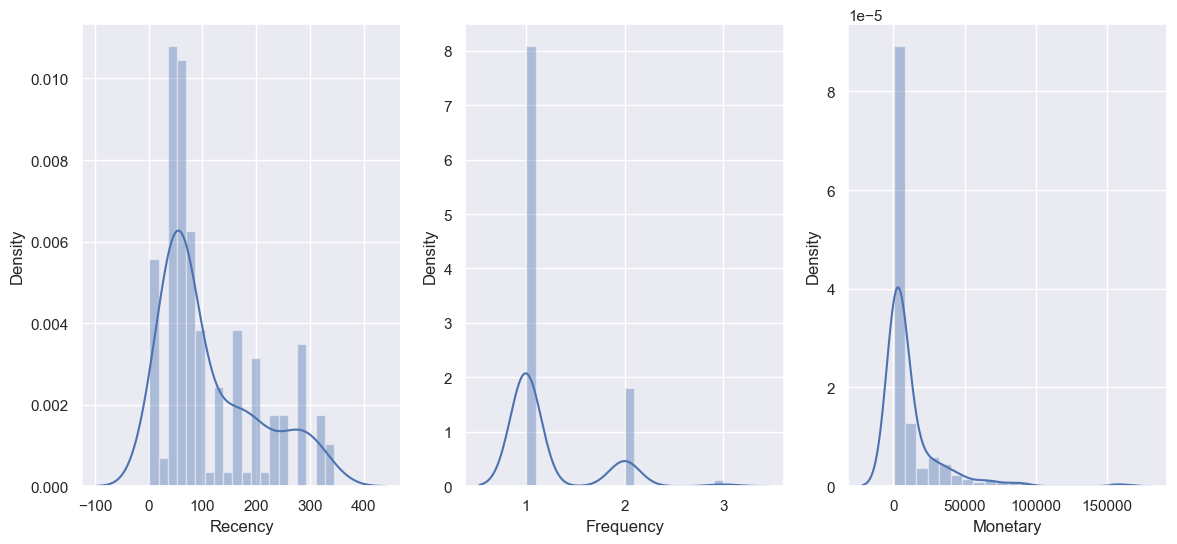

In [99]:
# Distribution of RFM features
display(RFM.drop('user_id',axis=1).describe())

# Distributions of Recency, Frequency, and Monetary features
fig, ax = plt.subplots(1,3, figsize=(14,6))
sns.distplot(RFM.Recency, bins=20, ax=ax[0])
sns.distplot(RFM['Frequency'], bins=20, ax=ax[1])
sns.distplot(RFM['Monetary'], bins=20, ax=ax[2])
plt.show()

To conduct RFM analysis, we need to rank the customers based on each RFM attribute separately.

Assume that we rank these customers from 1-4 using RFM values. (1-low score & 4-High score)

Steps to be followed for RFM ranking:

Sort the Recency column by most recent purchases at the top. For Frequency and Monetary features sort it by the most frequent and most valuable purchases at the top.
If you are using N-scale ranking to rank the customers then you have to divide the sorted values of the features into 1/N groups. Here, we are using 4-scale ranking hence we need to divide the values into 4 groups.
we can do both the sorting and grouping using pandas df.quantile method by providing the number of quantiles as a list.

**NOTE:** The value of N decides the number of different RFM rank groups you want to create. All possible combination of ranks from 1-N for all the three RFM features results in N^3 rank groups ranging from 111(lowest) to NNN(highest).

In our case N=4, hence we could have a maximum of 4^3 = 64 rank groups with scores from 111 to 444.

In [100]:
RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])

,Recency,Frequency,Monetary
0.25,41.50,1.00,1575.00
0.50,72.00,1.00,3000.00
0.75,164.00,1.00,10700.00


In [101]:
# Creating quantiles 
Quantiles = RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])
Quantiles = Quantiles.to_dict()
Quantiles

{'Recency': {0.25: 41.5, 0.5: 72.0, 0.75: 164.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 1575.0, 0.5: 3000.0, 0.75: 10700.0}}

In [102]:
# Creating RFM ranks
def RFMRanking(x, variable, quantile_dict):
    ''' Ranking the Recency, Frequency, and Monetary features based on quantile values '''
    
    # checking if the feature to rank is Recency
    if variable == 'Recency':
        if x <= quantile_dict[variable][0.25]:
            return 4
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 3
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 2
        else:
            return 1
    
    # checking if the feature to rank is Frequency and Monetary
    if variable in ('Frequency','Monetary'):
        if x <= quantile_dict[variable][0.25]:
            return 1
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 2
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 3
        else:
            return 4

In [103]:
RFM['R'] = RFM['Recency'].apply(lambda x: RFMRanking(x, variable='Recency', quantile_dict=Quantiles))
RFM['F'] = RFM['Frequency'].apply(lambda x: RFMRanking(x, variable='Frequency', quantile_dict=Quantiles))
RFM['M'] = RFM['Monetary'].apply(lambda x: RFMRanking(x, variable='Monetary', quantile_dict=Quantiles))

In [104]:
print(RFM.shape)
RFM.head()

(167, 7)


,user_id,Recency,Frequency,Monetary,R,F,M
0,51448162784,10,2,21500.00,4,4,4
1,51455512201,64,1,10000.00,3,1,3
2,51462598385,7,2,550.00,4,4,1
3,51463622150,40,2,950.00,4,4,1
4,51465529647,10,2,15500.00,4,4,4


In [105]:
RFM['Group'] = RFM['R'].apply(str) + RFM['F'].apply(str) + RFM['M'].apply(str)
RFM.head()

,user_id,Recency,Frequency,Monetary,R,F,M,Group
0,51448162784,10,2,21500.00,4,4,4,444
1,51455512201,64,1,10000.00,3,1,3,313
2,51462598385,7,2,550.00,4,4,1,441
3,51463622150,40,2,950.00,4,4,1,441
4,51465529647,10,2,15500.00,4,4,4,444


In [106]:
RFM["Score"] = RFM[['R', 'F', 'M']].sum(axis=1)
RFM.head()

,user_id,Recency,Frequency,Monetary,R,F,M,Group,Score
0,51448162784,10,2,21500.00,4,4,4,444,12
1,51455512201,64,1,10000.00,3,1,3,313,7
2,51462598385,7,2,550.00,4,4,1,441,9
3,51463622150,40,2,950.00,4,4,1,441,9
4,51465529647,10,2,15500.00,4,4,4,444,12


Since the highest score is 12, we may calculate the probability of a user purchase by dividing each user score per 12. Something like this:

##### Probability to purchase of each user
RFM["probability_to_purchase"] = RFM["Score"]/12

In [107]:
# Loyalty levels
#loyalty = ['Bronze', 'Silver', 'Gold', 'Platinum']
#RFM['Loyalty_Level'] = pd.qcut(RFM['Score'], q=4, labels= loyalty)
#RFM.head()

In [108]:
#behaviour = RFM.groupby('Loyalty_Level')[['Recency', 'Frequency', 'Monetary', 'Score']].mean()
#behaviour

There are two broad ways in which the RFM features can be utilized:
* **Preferrential Treatments:** RFM features and loyalty tags will be available only for existing users. So, whenever old users shows interest in any product, based on their loyalty tags we can target them with personalized discounts etc.


* **High value path:** We can analyze the behaviour exhibited by the old users and create multiple behaviour paths that leads to increased purchase. This learning can then be used to nudge new users to follow such paths and hence increase the probability of purchase.

### 2.5.1. Adding the RFM Features to df2

In [109]:
df2 = pd.merge(df2, RFM, on='user_id', how='left')
print(df2.shape)
df2.head()

(2090, 37)


,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,...,subcategory_number_of_product_view_to_purchase_ratio,target,Recency,Frequency,Monetary,R,F,M,Group,Score
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,...,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,...,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,...,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,men_fashion,jeans,product_view,0.00,0.00,0.00,2019,...,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,men_fashion,jeans,read_reviews,0.00,0.00,0.00,2019,...,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
df2.isna().sum()

user_id                                                      0
session_id                                                   0
date_time                                                    0
category                                                     0
sub_category                                                 0
action                                                       0
quantity                                                     0
rate                                                         0
total_price                                                  0
year                                                         0
month                                                        0
day                                                          0
day_of_week                                                  0
week_of_year                                                 0
number_of_days_active                                        0
avg_days_between_purchase                              

## 2.6. Na Check for Feature Engineering

In [111]:
df2.isna().sum()

user_id                                                      0
session_id                                                   0
date_time                                                    0
category                                                     0
sub_category                                                 0
action                                                       0
quantity                                                     0
rate                                                         0
total_price                                                  0
year                                                         0
month                                                        0
day                                                          0
day_of_week                                                  0
week_of_year                                                 0
number_of_days_active                                        0
avg_days_between_purchase                              

Imputation Strategy:

* avg_time_between_purchase --> -1 imputation (since most users in the dataset is first time this feature has more NaN values). If we put 0, we would be assuming the user purchased and that happened at least twice in the same day. 


* Rest all features --> 0 imputation

In [112]:
#df2["Loyalty_Level"].unique()

In [113]:
#df2.drop("Loyalty_Level", axis=1)
#df2.head(3)

In [114]:
# Null values imputation
df2['avg_days_between_purchase'] = df2['avg_days_between_purchase'].fillna(-1)
df2['Group'] = df2['Group'].fillna("-1")

#df = pd.DataFrame({'Loyalty_Level': ['Platinum', 'Gold', 'Silver', 'Bronze', float('nan')]})
#df['Loyalty_Level'] = df['Loyalty_Level'].astype('category', categories=['Platinum', 'Gold', 'Silver', 'Bronze'], ordered=False)
#df['Loyalty_Level'] = df['Loyalty_Level'].cat.add_categories(['not_client'])
#df['Loyalty_Level'] = df['Loyalty_Level'].fillna('not_client')
#df2.drop(columns="Loyalty_Level", axis=1)

df2 = df2.fillna(0)
df2.isna().sum()

user_id                                                   0
session_id                                                0
date_time                                                 0
category                                                  0
sub_category                                              0
action                                                    0
quantity                                                  0
rate                                                      0
total_price                                               0
year                                                      0
month                                                     0
day                                                       0
day_of_week                                               0
week_of_year                                              0
number_of_days_active                                     0
avg_days_between_purchase                                 0
number_of_carts_to_purchase_ratio       

# 3. Feature Filtering and Selection

We are going to filter rows and select columns based on the previous data description section. 

In [115]:
df3 = df2.copy()

## 3.1. Feature Filtering

Removing outliers based on 75 percentile. 

In [116]:
df3 = df3[(df3["quantity"] < 100) & (df3["rate"] <= 6000) 
          & (df3["total_price"] <= 8000)]

## 3.2. Columns Selection

Based on the section 1.6.4, we chose the category column to be removed. We must have the minimum number of columns which describe the same phenomenon in the model in order to avoid overfitting.

In [117]:
cols_drop = ["category"]
df3 = df3.drop(cols_drop, axis=1)

In [118]:
df2.shape

(2090, 37)

In [119]:
df3.shape

(2032, 36)

# 4. Balanced Dataset

In [120]:
df4 = df3.copy()

## 4.1. Check Balanced Data

This section is necessary when there is a great imbalance between classes of a dataset. When this phenomenon occurs, the model becomes biased. In this section, we balanced our dataset. After balance, we may look at accuracy instead of balanced accuracy - this metric does not make sense anymore since the data will be balanced.

**CAUTION:** we use balanced data to train the model, not for Exploratory Data Analysis, since they are synthetic data.

A classification problem is considered imbalanced when the distribution of class labels is uneven, meaning that one or more classes have a much smaller number of samples than the other classes. This can cause issues in learning algorithms, as the minority class samples might not be representative of the true distribution, leading to a model that is biased towards the majority class.

There is no hard and fast rule to determine when a binary classification problem is considered imbalanced. The threshold of class imbalance is often subjective and depends on the specific problem and application.

However, in general, if the minority class has less than 10-20% of the total samples, the dataset can be considered imbalanced. If the imbalance is much greater, for example, the minority class having less than 1% of the total samples, the problem can be considered highly imbalanced.

It is important to keep in mind that the threshold for class imbalance can vary based on the size of the dataset, the nature of the problem, and the goals of the analysis. It's always best to examine the class distribution and make an informed decision about what constitutes imbalance for a specific problem.

In [121]:
df4["target"].value_counts()

1.00    1168
0.00     864
Name: target, dtype: int64

In [122]:
df4["target"].value_counts(normalize=True)

1.00   0.57
0.00   0.43
Name: target, dtype: float64

As we are working with a propensity problem, we may consider an imbalance. With the minority class having approximately 43% of the total samples, it can be considered to have a moderate class imbalance. This can potentially lead to a biased model that performs well on the majority class but poorly on the minority class. In this situation, techniques to balance the class distribution, such as oversampling the minority class or undersampling the majority class, could be considered to mitigate the issue.

In [123]:
df4.shape

(2032, 36)

In [124]:
df4.dtypes

user_id                                                            int64
session_id                                                        object
date_time                                                 datetime64[ns]
sub_category                                                      object
action                                                            object
quantity                                                         float64
rate                                                             float64
total_price                                                      float64
year                                                               int64
month                                                              int64
day                                                                int64
day_of_week                                                        int64
week_of_year                                                       int64
number_of_days_active                              

In [125]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes(include=['int64', 'float64']).drop(['user_id', 'target'], axis=1).columns.tolist()

# Categorical
col_cat = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop('session_id', axis=1).columns.tolist()

# encoding
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index=df4.index)

# join numerical and categorical
df42 = pd.concat([df4[col_num], df4_dummy], axis=1)
df42.shape

(2032, 437)

## 4.2. Random Oversampling

This technique consists of taking random samples from a minority class until the amount of data is the same of a manjority class. We use this technique when (1) it is not possible to collect more data of the classes and (2) the problem is not naturally imbalanced (e.g.: Fraud problems).

**Advantages:** Easy and fast technique.

**Disadvantages:** (1) Enhancement of repetition for training examples; (2) Enhancement of overfitting probability; (3) No further information about the phenomenon, as we use data from sample.

In [126]:
# define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='all', random_state=32)

# apply sampler
X_over, y_over = oversampling.fit_resample(df42, df4['target'])

In [127]:
df4['target'].value_counts()

1.00    1168
0.00     864
Name: target, dtype: int64

In [128]:
y_over.value_counts()

0.00    1168
1.00    1168
Name: target, dtype: int64

In [129]:
# numerical data
df47 = X_over[col_num]

# categorical data
df48 = X_over.drop(col_num, axis=1)
df49 = pd.DataFrame(ohe.inverse_transform(df48), columns=col_cat, index=df48.index)

# join numerical categorical
df50 = pd.concat([df47, df49], axis=1)
df50['target'] = y_over

In [130]:
df50.head(3)

,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,...,Monetary,R,F,M,Score,sub_category,action,top_paths,Group,target
0,0.00,0.00,0.00,2019,1,10,3,2,2,-1.00,...,0.00,0.00,0.00,0.00,0.00,speakers,first_app_open,Not added to cart,-1,0.00
1,0.00,0.00,0.00,2019,1,10,3,2,2,-1.00,...,0.00,0.00,0.00,0.00,0.00,speakers,search,Not added to cart,-1,0.00
2,0.00,0.00,0.00,2019,1,10,3,2,3,-1.00,...,0.00,0.00,0.00,0.00,0.00,jeans,search,Not added to cart,-1,0.00


In [131]:
df50.columns

Index(['quantity', 'rate', 'total_price', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'number_of_days_active',
       'avg_days_between_purchase', 'number_of_carts_to_purchase_ratio',
       'number_of_click_wishlist_to_purchase_ratio',
       'number_of_add_wishlist_to_purchase_ratio',
       'category_number_of_carts_to_purchase_ratio',
       'subcategory_number_of_carts_to_purchase_ratio',
       'category_number_of_click_wishlist_to_purchase_ratio',
       'subcategory_number_of_click_wishlist_to_purchase_ratio',
       'category_number_of_add_wishlist_to_purchase_ratio',
       'subcategory_number_of_add_wishlist_to_purchase_ratio',
       'category_number_of_product_view_to_purchase_ratio',
       'subcategory_number_of_product_view_to_purchase_ratio', 'Recency',
       'Frequency', 'Monetary', 'R', 'F', 'M', 'Score', 'sub_category',
       'action', 'top_paths', 'Group', 'target'],
      dtype='object')

# 5. Exploratory Data Analysis (EDA)

The main objectives of this section is:

- To acquire business experience from data.
- To generate insights to the business team.
- To evaluate features impact over the phenomenon.

In [132]:
df5 = df2.copy()

In [133]:
df5.head()

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,...,subcategory_number_of_product_view_to_purchase_ratio,target,Recency,Frequency,Monetary,R,F,M,Group,Score
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,...,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1,0.00
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,...,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1,0.00
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,...,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1,0.00
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,men_fashion,jeans,product_view,0.00,0.00,0.00,2019,...,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1,0.00
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,men_fashion,jeans,read_reviews,0.00,0.00,0.00,2019,...,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1,0.00


## 5.1. Univariate Analysis

In [134]:
#profile = ProfileReport(df5, title='Customer Propensity to Purchase')
#profile.to_file(output_file='customer_propensity_purchase_statistics_after_cleaning.html')

We found that the columns quantity, rate and total_price are high correlation with each other. We are going to better analyze before deciding remove each of them.

In [135]:
# Timerange of data
print("Min Date: " +str(df5.date_time.min()))
print("Max Date: " +str(df5.date_time.max()))
print("Range: " +str(df5.date_time.max()-df5.date_time.min()))

Min Date: 2019-01-01 11:00:00
Max Date: 2019-12-22 17:52:00
Range: 355 days 06:52:00


In [136]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df5[df5["quantity"] > 0].describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,201.00,53901272628.92,2816738504.08,51448162784.00,51725305614.00,52313781035.00,55538327311.00,60302643179.00
quantity,201.00,2.97,7.16,1.00,1.00,2.00,3.00,100.00
rate,201.00,7133.28,14778.15,10.00,500.00,1200.00,6000.00,90000.00
total_price,201.00,9455.37,18213.70,150.00,1000.00,2500.00,8000.00,160000.00
year,201.00,2019.00,0.00,2019.00,2019.00,2019.00,2019.00,2019.00
month,201.00,8.29,3.04,1.00,6.00,10.00,10.00,12.00
day,201.00,14.15,6.18,1.00,11.00,11.00,17.00,31.00
day_of_week,201.00,2.32,1.89,0.00,0.00,2.00,4.00,6.00
week_of_year,201.00,34.27,13.31,2.00,24.00,41.00,44.00,51.00
number_of_days_active,201.00,9.09,6.08,2.00,4.00,6.00,14.00,25.00


The three variables have the same count. We may not choose any variable based on a minor count though.

Total Unique Categories: 101


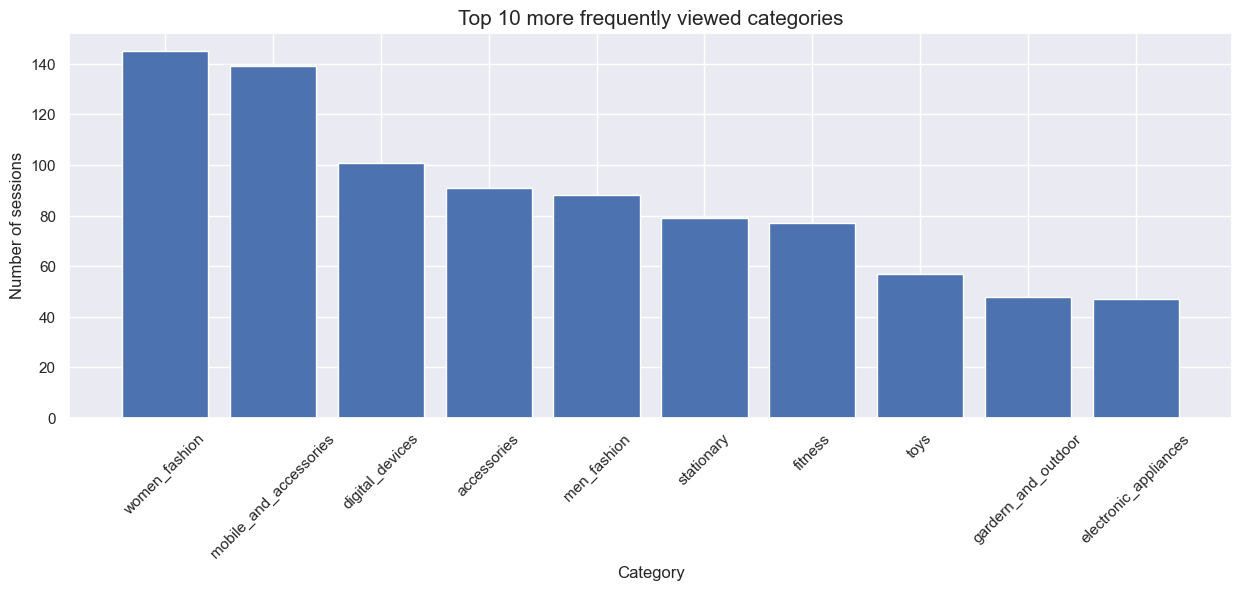

In [137]:
# Distribution of Category
print("Total Unique Categories: " + str(df5.category.nunique()))
temp_category = df5.groupby('category')['session_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15,5))
plt.bar(temp_category.category, temp_category.session_id)
plt.title("Top 10 more frequently viewed categories", size=15)
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Number of sessions")
plt.show()

Total Unique SubCategories: 358


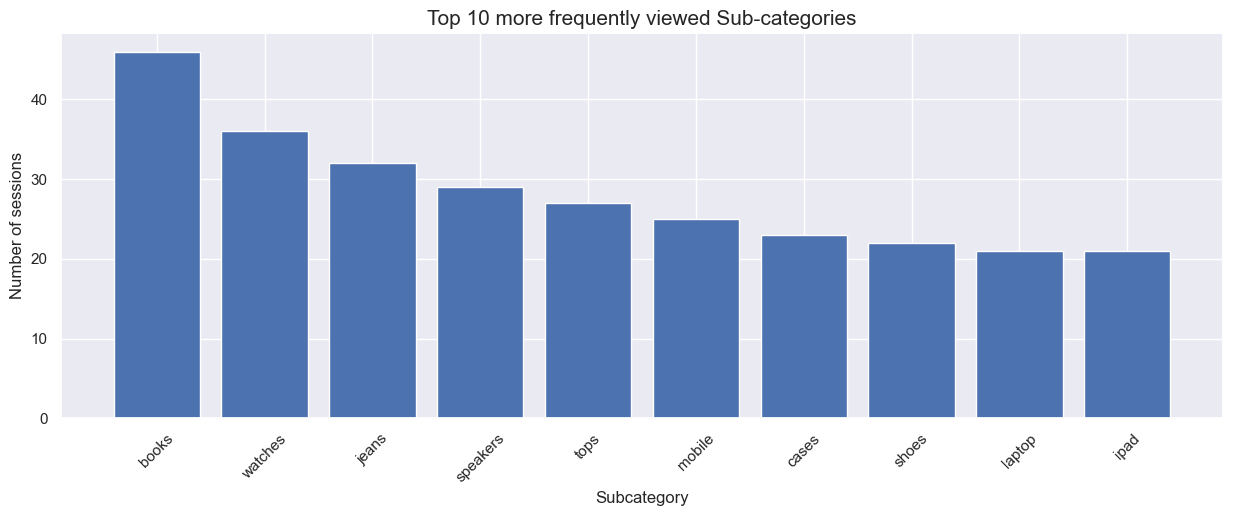

In [138]:
# Distribution of SubCategory
print("Total Unique SubCategories: " + str(df5.sub_category.nunique()))
temp_subcategory = df5.groupby('sub_category')['session_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15,5))
plt.bar(temp_subcategory.sub_category, temp_subcategory.session_id)
plt.title("Top 10 more frequently viewed Sub-categories", size=15)
plt.xticks(rotation=45)
plt.xlabel("Subcategory")
plt.ylabel("Number of sessions")
plt.show()

read_reviews           343
search                 320
product_view           292
add_to_cart            280
checkout               202
click_wishlist_page    202
purchase               201
first_app_open         121
add_review              69
add_to_wishlist         38
product_review          22
Name: action, dtype: int64

Total Unique Actions: 11


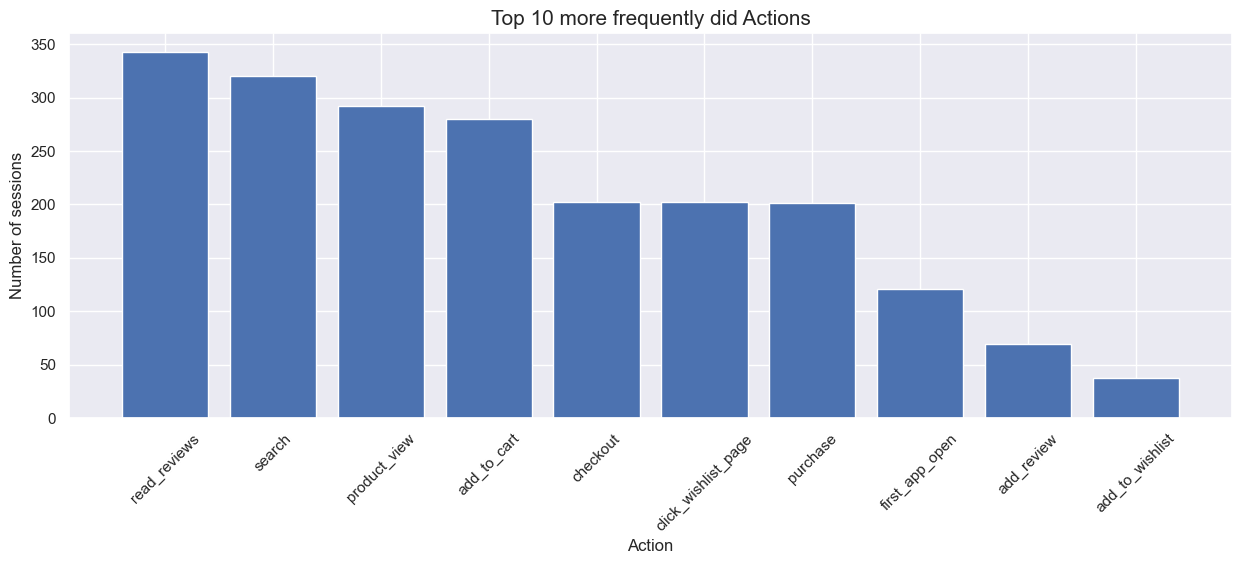

In [139]:
# Distribution of Action
display(df5.action.value_counts())

print("Total Unique Actions: " + str(df5.action.nunique()))
temp_actions = df5.groupby('action')['session_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15,5))
plt.bar(temp_actions.action, temp_actions.session_id)
plt.title("Top 10 more frequently did Actions", size=15)
plt.xticks(rotation=45)
plt.xlabel("Action")
plt.ylabel("Number of sessions")
plt.show()

## 5.2 Bivariate Analysis

We are going to perform bivariate analysis in order evaluate how the features are correlated with the target variable.

Based on the initial understanding of the different columns in the data (univariate analysis), we can create some hypothesis (if any) or try to ask more complex questions such as:

1. How many unique users in the data and how many of them purchased at least once? Also, what is the average number of purchase per customer?
2. Which is the most purchased Category/Sub-category?
3. Do people add the products to cart before they purchase or buy directly?
4. What is the average time taken by a user to buy a product?
5. What is the average time between repeat purchase?
6. What is the trend of unique users across the time period?
7. What is the trend of purchase across the time period?

This is not the exhaustive list but good to start with.

#### 1. How many unique users in the data and how many of them purchased at least once? Also, what is the average number of purchase per customer?

The "agg" function in Python: this is typically used to aggregate data in a DataFrame. Specifically, it is counting the number of rows in the "sub_category" column of the DataFrame. As we are filtering the sub_category "purchase", we see the number of rows for purchase. The result of this function would be a single value representing the count of rows in the "sub_category" column equals to "purchase". As we grouped by user_id before, thus the result is the number of purchase rows per user_id (an average value). 

In [140]:
# unique customers 
total_users = df5.user_id.nunique()
print(f"Total customers: {total_users}.")

# at least 1 purchase customer
atleast_one_purchase_cust = df5[df5['action']=='purchase']['user_id'].nunique()
conversion = 100*round(atleast_one_purchase_cust/total_users, 2)
print(f"Customers who made at least 1 purchase: {atleast_one_purchase_cust} ({conversion}% conversion)")

# avg purchase per customer
purch_dist_by_cust = (df5[df5['action']=='purchase'].groupby('user_id').agg({'sub_category': 'count'})
                      .reset_index().sort_values(by='sub_category', ascending=False) # True or False
                     )
purch_dist_by_cust.rename(columns={'sub_category':'number_of_purchase'}, inplace=True)

print(f"Average number of purchase per customer: {round(purch_dist_by_cust.number_of_purchase.mean(), 2)}")

print("\nDistribution of Number of Purchases:")
display(purch_dist_by_cust[['number_of_purchase']].describe())

Total customers: 401.
Customers who made at least 1 purchase: 167 (42.0% conversion)
Average number of purchase per customer: 1.2

Distribution of Number of Purchases:


,number_of_purchase
count,167.00
mean,1.20
std,0.43
min,1.00
25%,1.00
50%,1.00
75%,1.00
max,3.00


#### 2. Which is the most purchased category and sub-category? 

We considered the number of distinct users who purchased in the categories, not the quantity.

Total Unique Categories: 101


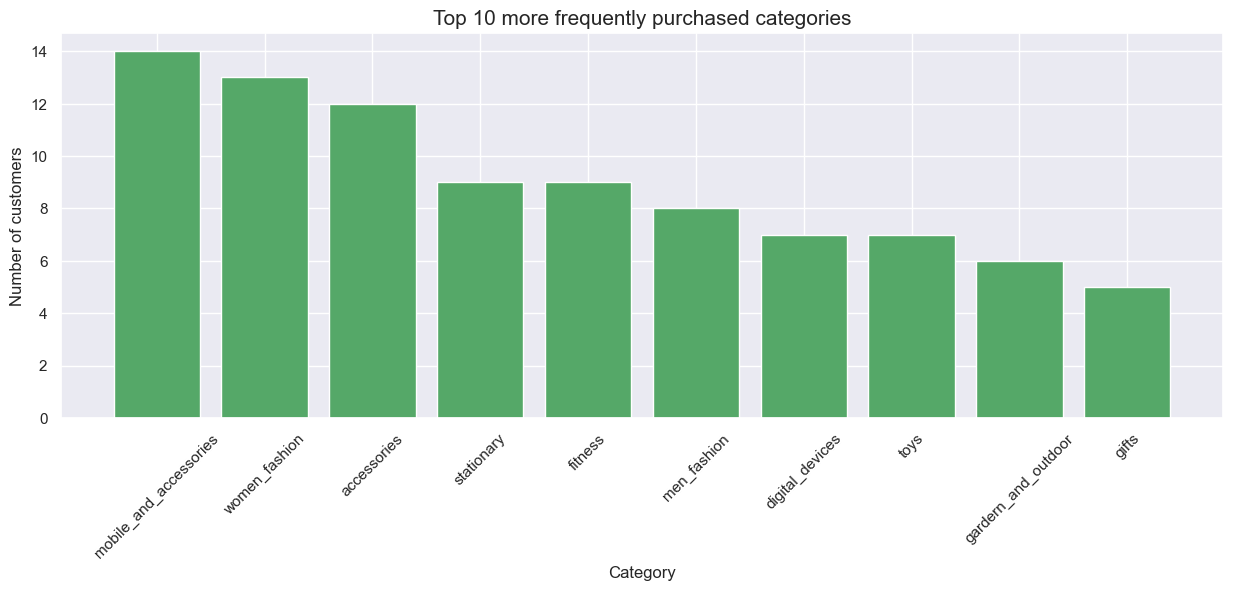

Total Unique Sub-categories: 358


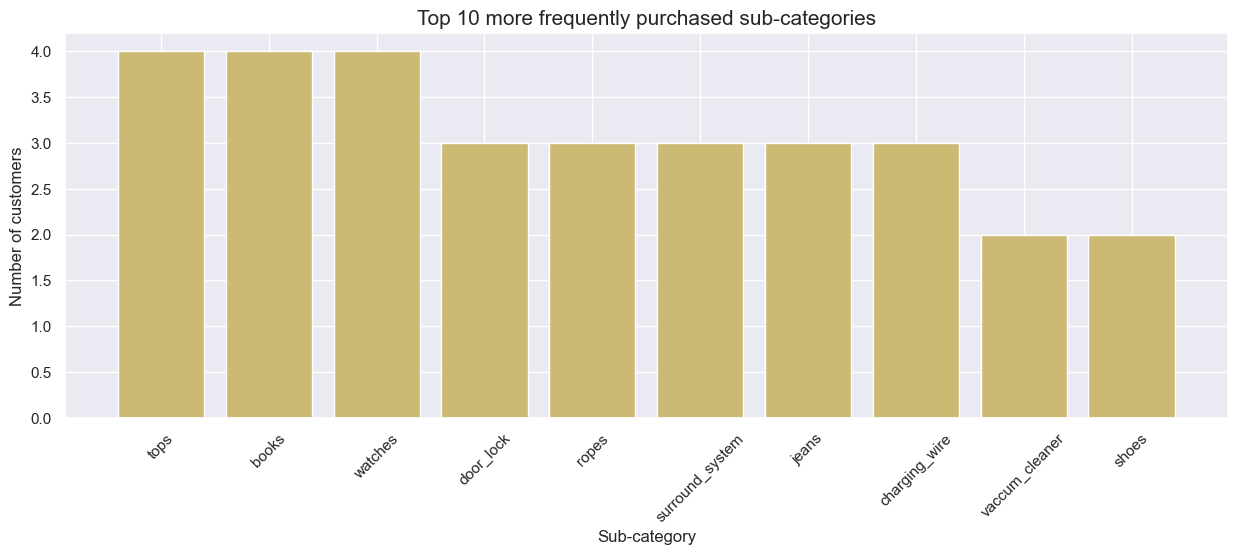

In [141]:
# Top 10 purchased categories
print("Total Unique Categories: {}".format(df5.category.nunique()))
temp_category = df5[df5['action']=='purchase'].groupby('category')['user_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15, 5))
plt.bar(temp_category.category, temp_category.user_id, color='g')
plt.title("Top 10 more frequently purchased categories", size=15)
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Number of customers")
plt.show()

# Top 10 purchased SubCategory
print("Total Unique Sub-categories: {}".format(df5.sub_category.nunique()))
temp_subcategory = df5[df5['action']=='purchase'].groupby('sub_category')['user_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15, 5))
plt.bar(temp_subcategory.sub_category, temp_subcategory.user_id, color='y')
plt.title("Top 10 more frequently purchased sub-categories", size=15)
plt.xticks(rotation=45)
plt.xlabel("Sub-category")
plt.ylabel("Number of customers")
plt.show()

#### 3. Do people add the products to cart before they purchase or buy directly?

In [142]:
# direct purchase
purchase_users = df5[df5['action']=='purchase'].groupby('user_id')['action'].count().reset_index()

# add to cart
cart_users = df5[df5['action']=='add_to_cart'].groupby('user_id')['action'].count().reset_index()

# merge
temp_direct = pd.merge(purchase_users, cart_users, on='user_id', how='left', indicator=True)
temp_cart = pd.merge(cart_users, purchase_users, on='user_id', how='left', indicator=True)

In [143]:
temp_direct

,user_id,action_x,action_y,_merge
0,51448162784,2,2.00,both
1,51455512201,1,1.00,both
2,51462598385,2,2.00,both
3,51463622150,2,2.00,both
4,51465529647,2,3.00,both
...,...,...,...,...
162,60029406377,1,NaN,left_only
163,60034334067,1,1.00,both
164,60089394505,1,1.00,both
165,60238282834,3,3.00,both


In [144]:
temp_cart

,user_id,action_x,action_y,_merge
0,51448162784,2,2.00,both
1,51455512201,1,1.00,both
2,51462598385,2,2.00,both
3,51463622150,2,2.00,both
4,51465529647,3,2.00,both
...,...,...,...,...
235,60034334067,1,1.00,both
236,60089394505,1,1.00,both
237,60238282834,3,3.00,both
238,60300257008,1,NaN,left_only


In [145]:
direct_buy = temp_direct[temp_direct['_merge']=='left_only'].shape[0]
cart_only = temp_cart[temp_cart['_merge']=='left_only'].shape[0] # added to cart but not purchased

In [146]:
print("Total unique users who purchased: {}.".format(purchase_users.shape[0]))
print("Total direct buy (without adding to cart): {}.".format(direct_buy))
print("Total add_to_cart buy: {}.".format(cart_users.shape[0] - cart_only))

print("\nTotal unique users who added to cart: {}.".format(cart_users.shape[0]))
print("Total users who only added to cart (no purchase): {}.".format(cart_only))

Total unique users who purchased: 167.
Total direct buy (without adding to cart): 20.
Total add_to_cart buy: 147.

Total unique users who added to cart: 240.
Total users who only added to cart (no purchase): 93.


#### 4. What is the average and median time taken by a user to buy a product?

In [147]:
# purchases per distinct customer
purch_dist_by_cust

,user_id,number_of_purchase
165,60238282834,3
17,51565158157,3
0,51448162784,2
108,53966220604,2
34,51725305614,2
...,...,...
66,52114046370,1
65,52112239597,1
64,52094145973,1
63,52090547553,1


In [148]:
# Also after purchase users are either adding review or not. But since add_review event is low (69), ignoring it now
temp = df5.copy()
temp = pd.merge(temp, purch_dist_by_cust, on='user_id', how='left')
temp['number_of_purchase'] = temp['number_of_purchase'].fillna(0)

# max and min purchase datetime per user
temp['min_time'] = temp.groupby('user_id')['date_time'].transform(min) # initial time
temp['max_purchase_time'] = temp.groupby('user_id')['date_time'].transform(max) # purchase time

In [149]:
temp.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,...,Frequency,Monetary,R,F,M,Group,Score,number_of_purchase,min_time,max_purchase_time
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,...,0.00,0.00,0.00,0.00,0.00,-1,0.00,0.00,2019-01-10 10:20:00,2019-01-10 10:22:00
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,...,0.00,0.00,0.00,0.00,0.00,-1,0.00,0.00,2019-01-10 10:20:00,2019-01-10 10:22:00
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,...,0.00,0.00,0.00,0.00,0.00,-1,0.00,0.00,2019-01-10 14:00:00,2019-01-10 14:12:00



Summary stats (Time diff in days):


,time_diff_days
count,2090.00
mean,58.56
std,94.37
min,0.00
25%,0.00
50%,0.00
75%,105.00
max,335.00


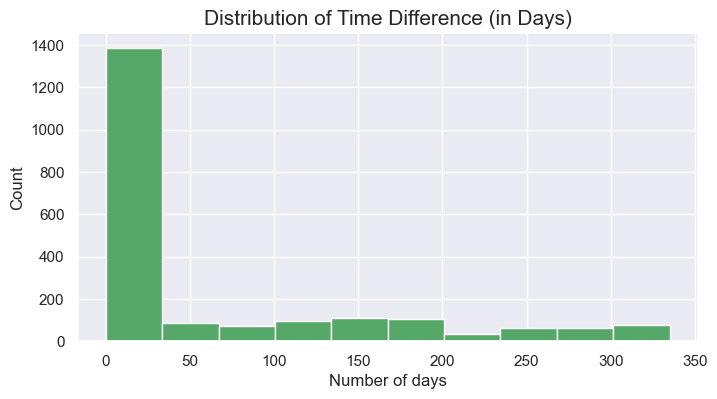

In [150]:
# Time difference between max and min datetime 
temp['time_diff_days'] = (temp['max_purchase_time'] - temp['min_time']).dt.days

print("\nSummary stats (Time diff in days):")
display(temp[['time_diff_days']].describe())

plt.figure(figsize=(8,4))
plt.hist(temp['time_diff_days'], density=False, color='g')
plt.title("Distribution of Time Difference (in Days)", size=15)
plt.xlabel("Number of days")
plt.ylabel("Count")
plt.show()


Summary stats (Time diff in minutes):


,time_diff_minutes
count,2090.00
mean,231.71
std,394.75
min,0.00
25%,14.00
50%,30.00
75%,242.00
max,1404.00


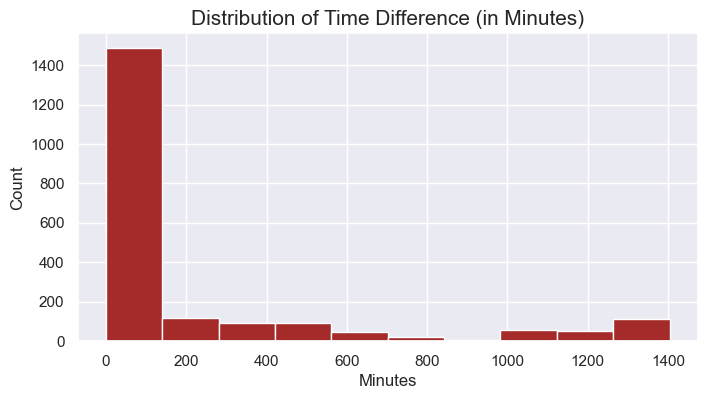

In [151]:
# Time difference between max and min datetime 
temp['time_diff_minutes'] = (temp['max_purchase_time'] - temp['min_time']).dt.seconds/60

print("\nSummary stats (Time diff in minutes):")
display(temp[['time_diff_minutes']].describe())

plt.figure(figsize=(8,4))
plt.hist(temp['time_diff_minutes'], density=False, color='brown')
plt.title("Distribution of Time Difference (in Minutes)", size=15)
plt.xlabel("Minutes")
plt.ylabel("Count")

plt.show()

To look at the median time is more realistic since average is biased for outliers.

- Average time to buy: 231 minutes.
- Median time to buy: 30 minutes.

#### 5. What is the average and median time between repeated purchases?

In [152]:
# Average time between repeat purchase
temp = df5.copy()
temp = pd.merge(temp, purch_dist_by_cust, on='user_id', how='left')
temp['number_of_purchase'] = temp['number_of_purchase'].fillna(0)
temp = temp[temp['number_of_purchase'] > 1].reset_index(drop=True)
print("Total users who made more than 1 purchase: {}.".format(temp.user_id.nunique()))

Total users who made more than 1 purchase: 32.


In [153]:
test = temp[temp['action']=='purchase'].sort_values(by=['user_id','date_time'])
test = test.groupby('user_id').agg({'date_time': lambda x: list(x)})

In [154]:
test

,date_time
user_id,
51448162784,"[2019-06-11 13:23:00, 2019-12-12 19:22:00]"
51462598385,"[2019-10-20 17:30:00, 2019-12-15 19:03:00]"
51463622150,"[2019-10-14 21:44:00, 2019-11-12 21:27:00]"
51465529647,"[2019-12-05 19:30:00, 2019-12-12 21:15:00]"
51480378215,"[2019-04-09 17:24:00, 2019-10-24 21:18:00]"
51481443687,"[2019-05-11 13:23:00, 2019-08-16 11:27:00]"
51517997197,"[2019-07-18 18:27:00, 2019-10-22 18:12:00]"
51526464449,"[2019-09-25 14:38:00, 2019-10-28 18:23:00]"
51565158157,"[2019-06-18 11:17:00, 2019-08-23 18:32:00, 201..."


In [155]:
def purch_time_diff(x):
    if len(x) == 2:
        return (x[1]-x[0]).days

    if len(x) == 3:
        diff_12 = (x[1]-x[0]).days
        diff_23 = (x[2]-x[1]).days
        return (diff_12 + diff_23)/2
    
test['diff'] = test['date_time'].apply(purch_time_diff)
test = test.reset_index()
test

,user_id,date_time,diff
0,51448162784,"[2019-06-11 13:23:00, 2019-12-12 19:22:00]",184.00
1,51462598385,"[2019-10-20 17:30:00, 2019-12-15 19:03:00]",56.00
2,51463622150,"[2019-10-14 21:44:00, 2019-11-12 21:27:00]",28.00
3,51465529647,"[2019-12-05 19:30:00, 2019-12-12 21:15:00]",7.00
4,51480378215,"[2019-04-09 17:24:00, 2019-10-24 21:18:00]",198.00
5,51481443687,"[2019-05-11 13:23:00, 2019-08-16 11:27:00]",96.00
6,51517997197,"[2019-07-18 18:27:00, 2019-10-22 18:12:00]",95.00
7,51526464449,"[2019-09-25 14:38:00, 2019-10-28 18:23:00]",33.00
8,51565158157,"[2019-06-18 11:17:00, 2019-08-23 18:32:00, 201...",57.00
9,51589427926,"[2019-04-03 11:17:00, 2019-10-23 20:23:00]",203.00



Summary stats (Time diff in days):


,diff
count,32.00
mean,101.03
std,76.82
min,0.00
25%,35.25
50%,90.50
75%,177.25
max,245.00


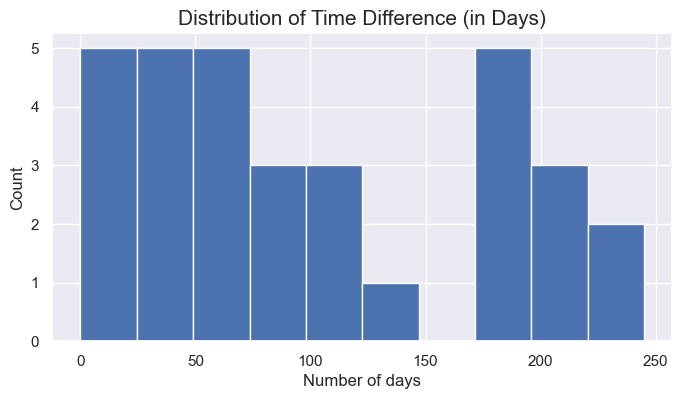

In [156]:
print("\nSummary stats (Time diff in days):")
display(test[['diff']].describe())

plt.figure(figsize=(8,4))
plt.hist(test['diff'], density=False, color='b')
plt.title("Distribution of Time Difference (in Days)",size=15)
plt.xlabel("Number of days")
plt.ylabel("Count")
plt.show()

- Average time: 101 days.
- Median time: 90 days.

#### 6. What is the trend of unique users across time period?

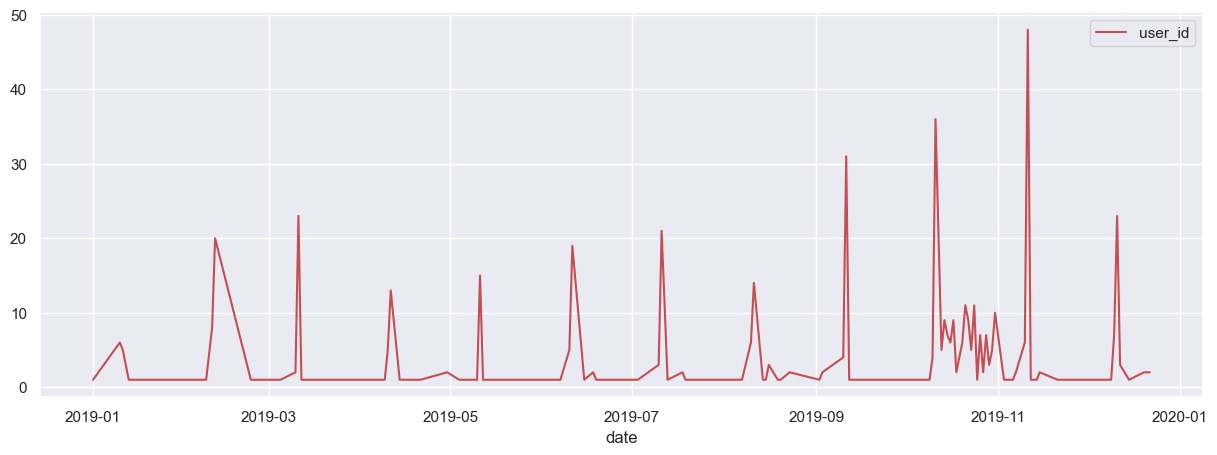

In [157]:
# Converting to date
temp = df5.copy()
temp['date'] = temp['date_time'].dt.date

# Number of unique customer per date
temp = temp.groupby('date').agg({'user_id': 'nunique'}).reset_index().sort_values(by='date')

# plot over time
temp.set_index('date').plot(figsize=(15,5), color='r')
plt.show()

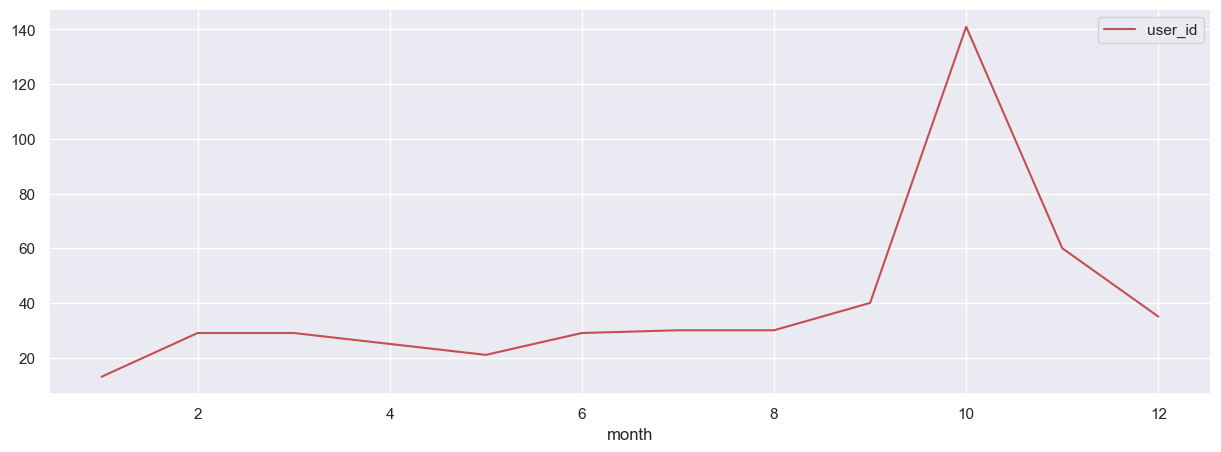

In [158]:
# Converting into month
temp = df5.copy()
temp['month'] = temp['date_time'].dt.month

# Number of unique users per month
temp = temp.groupby('month').agg({'user_id': 'nunique'}).reset_index().sort_values(by='month')

# plot over time
temp.set_index('month').plot(figsize=(15,5),color='r')
plt.show()

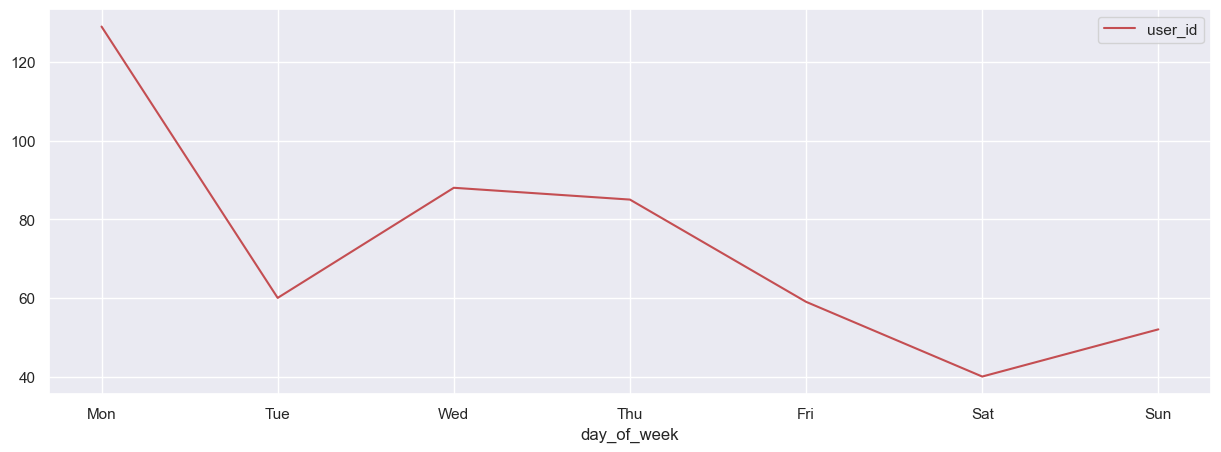

In [159]:
# Converting into day of week
temp = df5.copy()
temp['day_of_week'] = temp['date_time'].dt.dayofweek

# Number of unique users per day of week
temp = temp.groupby('day_of_week').agg({'user_id': 'nunique'}).reset_index().sort_values(by='day_of_week')

# plot over day of week
temp.set_index('day_of_week').plot(figsize=(15,5),color='r')
plt.xticks([0, 1, 2, 3, 4, 5, 6],['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

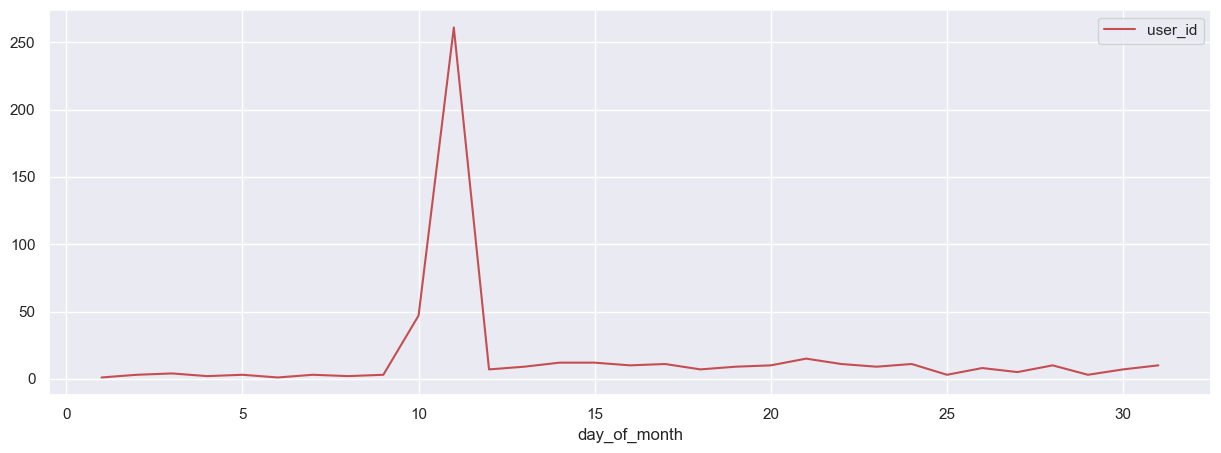

In [160]:
# Converting into day of month
temp = df5.copy()
temp['day_of_month'] = temp['date_time'].dt.day

# Number of unique users per day of month
temp = temp.groupby('day_of_month').agg({'user_id': 'nunique'}).reset_index().sort_values(by='day_of_month')

# Plot over day of month
temp.set_index('day_of_month').plot(figsize=(15,5),color='r')
plt.show()

#### 7. What is the trend of purchase across the time period?

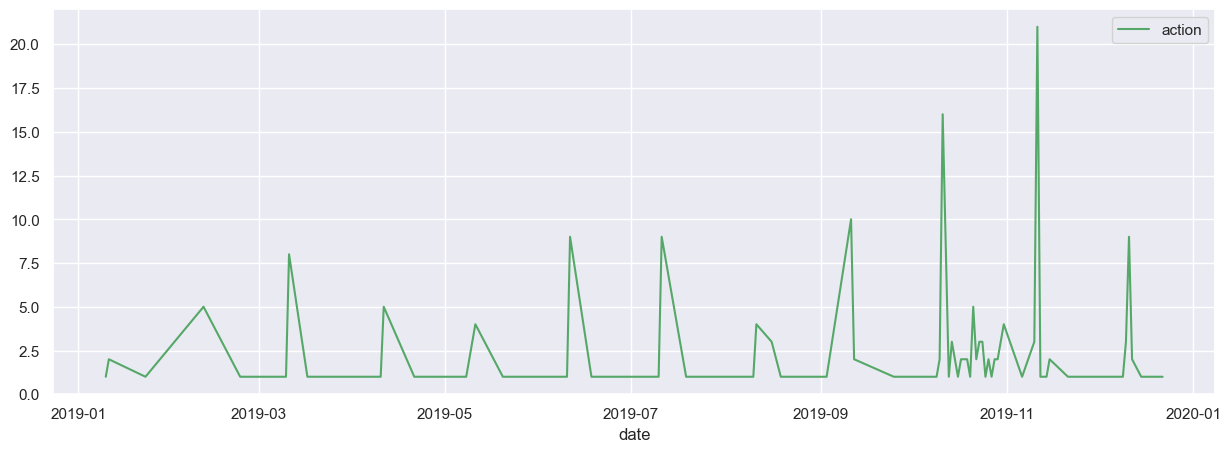

In [161]:
# Converting into date
temp = df5.copy()
temp['date'] = temp['date_time'].dt.date

# Number of unique users over the time
temp = temp[temp['action']=='purchase'].groupby('date').agg({'action': 'count'}).reset_index().sort_values(by='date')

# plot over the time
temp.set_index('date').plot(figsize=(15,5), color='g')
plt.show()

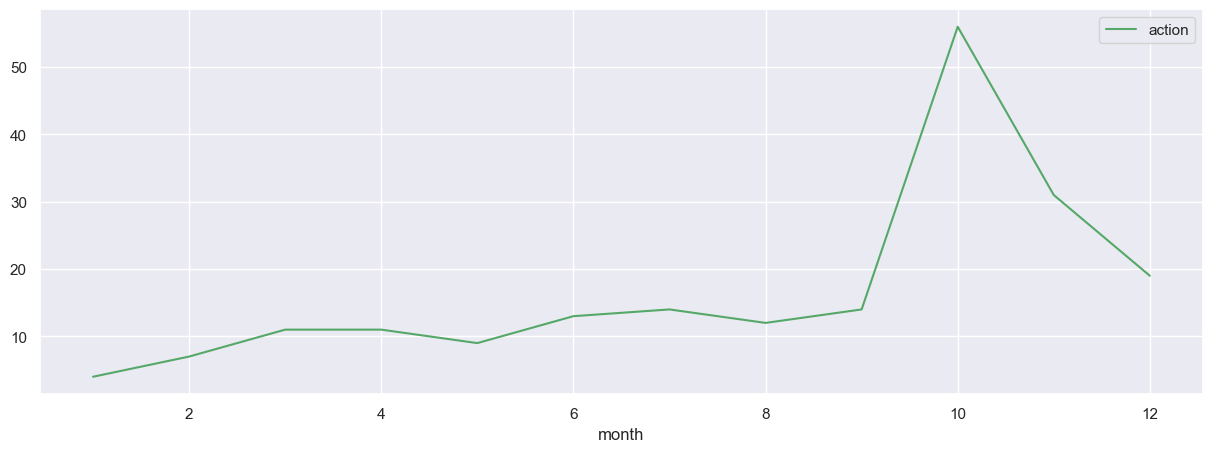

In [162]:
# Converting into date
temp = df5.copy()
temp['month'] = temp['date_time'].dt.month

# Number of unique users over the time
temp = temp[temp['action']=='purchase'].groupby('month').agg({'action': 'count'}).reset_index().sort_values(by='month')

# plot over the time
temp.set_index('month').plot(figsize=(15,5), color='g')
plt.show()

## 5.3. Multivariate Analysis

The main objective of this analysis is to evaluate the correlation between the variables. We only did multivariate analysis for numerical attributes, since we already did it for categorical data in the sections 1.7.4.

To analyze the correlation between numerical variables, we may use Pearson method. We cannot use this method to analyze categorical variables.

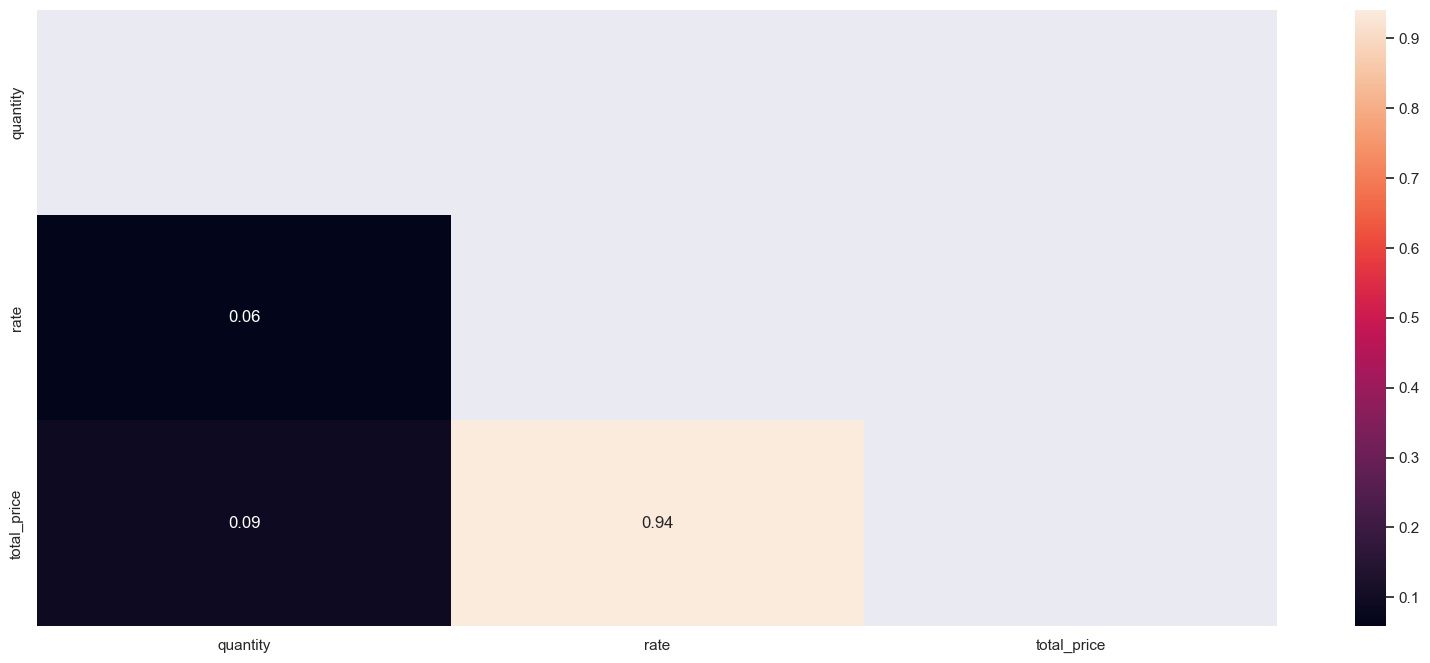

In [163]:
plt.figure(figsize = (20,8))

mask = np.zeros_like(num_attributes.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(num_attributes.corr(method="pearson"), mask = mask, annot=True);

- rate and total price are very correlated: 0.94.

Both of them have the same available count. Thus, we may choose any of them to be removed.

# 6. Data Pre-processing

From this point, we are going to work with the balanced dataset:

In [164]:
df6 = df50.copy()

There are 3 types of data preparation:

**Normalization:** the average is 0 and the standard deviation is 1. For data with normal distribution.

**Rescaling:** the range is between 0 and 1. (a) MinMax Scaler for data without outliers and (b) RobustScaler for data with outliers.

**Transformation:** (a) encoding of categorical variables and (b) nature transformation.

In [165]:
df6.head()

,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,...,Monetary,R,F,M,Score,sub_category,action,top_paths,Group,target
0,0.00,0.00,0.00,2019,1,10,3,2,2,-1.00,...,0.00,0.00,0.00,0.00,0.00,speakers,first_app_open,Not added to cart,-1,0.00
1,0.00,0.00,0.00,2019,1,10,3,2,2,-1.00,...,0.00,0.00,0.00,0.00,0.00,speakers,search,Not added to cart,-1,0.00
2,0.00,0.00,0.00,2019,1,10,3,2,3,-1.00,...,0.00,0.00,0.00,0.00,0.00,jeans,search,Not added to cart,-1,0.00
3,0.00,0.00,0.00,2019,1,10,3,2,3,-1.00,...,0.00,0.00,0.00,0.00,0.00,jeans,product_view,Not added to cart,-1,0.00
4,0.00,0.00,0.00,2019,1,10,3,2,3,-1.00,...,0.00,0.00,0.00,0.00,0.00,jeans,read_reviews,Not added to cart,-1,0.00


In [166]:
df6.columns

Index(['quantity', 'rate', 'total_price', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'number_of_days_active',
       'avg_days_between_purchase', 'number_of_carts_to_purchase_ratio',
       'number_of_click_wishlist_to_purchase_ratio',
       'number_of_add_wishlist_to_purchase_ratio',
       'category_number_of_carts_to_purchase_ratio',
       'subcategory_number_of_carts_to_purchase_ratio',
       'category_number_of_click_wishlist_to_purchase_ratio',
       'subcategory_number_of_click_wishlist_to_purchase_ratio',
       'category_number_of_add_wishlist_to_purchase_ratio',
       'subcategory_number_of_add_wishlist_to_purchase_ratio',
       'category_number_of_product_view_to_purchase_ratio',
       'subcategory_number_of_product_view_to_purchase_ratio', 'Recency',
       'Frequency', 'Monetary', 'R', 'F', 'M', 'Score', 'sub_category',
       'action', 'top_paths', 'Group', 'target'],
      dtype='object')

In [167]:
df6.dtypes

quantity                                                  float64
rate                                                      float64
total_price                                               float64
year                                                        int64
month                                                       int64
day                                                         int64
day_of_week                                                 int64
week_of_year                                                int64
number_of_days_active                                       int64
avg_days_between_purchase                                 float64
number_of_carts_to_purchase_ratio                         float64
number_of_click_wishlist_to_purchase_ratio                float64
number_of_add_wishlist_to_purchase_ratio                  float64
category_number_of_carts_to_purchase_ratio                float64
subcategory_number_of_carts_to_purchase_ratio             float64
category_n

## 6.1. Rescaling

In [168]:
#profile = ProfileReport(df6, title='Customer Propensity to Purchase')
#profile.to_file(output_file='customer_propensity_purchase_statistics_after_preprocessing.html')

Based on the pandas profiling report we generated, we are going to select the type of preparation for every variable. We saw in profiling report the variables distribution in order to better choose the scaler.

StandardScaler() is used in machine learning to normalize or scale the features of a dataset so that they have a mean of 0 and a standard deviation of 1. This is typically done to ensure that the features are on a similar scale and prevent some features from dominating others due to their large magnitude. By scaling the features, the algorithms can perform better and converge faster.

StandardScaler is used on variables (also known as features or predictors) that have a Gaussian distribution. Gaussian distributions are also known as normal distributions and are characterized by their bell-shaped curve. Features that follow a Gaussian distribution have a mean and standard deviation that can be used to represent the whole distribution. StandardScaler scales the features so that their mean is 0 and their standard deviation is 1.

It's important to note that StandardScaler assumes that the data is normally distributed, so it's not suitable for variables that have a different distribution, such as variables that are exponential or skewed. In such cases, it's recommended to use other normalization techniques or transform the data so that it has a Gaussian distribution (for this project: RobustScaler and MinMaxScaler).

In [169]:
ssc = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [170]:
# quantity - Robust Scaler
df6['quantity'] = rs.fit_transform(df6[['quantity']].values)

# rate - Robust Scaler
df6['rate'] = rs.fit_transform(df6[['rate']].values)

# total_price - Robust Scaler
df6['total_price'] = rs.fit_transform(df6[['total_price']].values)

# year - MinMax Scaler
df6['year'] = mms.fit_transform(df6[['year']].values)

# number_of_days_active - Robust Scaler
df6['number_of_days_active'] = rs.fit_transform(df6[['number_of_days_active']].values)

# avg_days_between_purchase - Robust Scaler
df6['avg_days_between_purchase'] = rs.fit_transform(df6[['avg_days_between_purchase']].values)

# number_of_carts_to_purchase_ratio - Robust Scaler
df6['number_of_carts_to_purchase_ratio'] = rs.fit_transform(df6[['number_of_carts_to_purchase_ratio']].values)

# number_of_carts_to_purchase_ratio - Robust Scaler
df6['number_of_click_wishlist_to_purchase_ratio'] = rs.fit_transform(df6[['number_of_click_wishlist_to_purchase_ratio']].values)

# number_of_add_wishlist_to_purchase_ratio - Robust Scaler
df6['number_of_add_wishlist_to_purchase_ratio'] = rs.fit_transform(df6[['number_of_add_wishlist_to_purchase_ratio']].values)

# category_number_of_carts_to_purchase_ratio - Standard
df6['category_number_of_carts_to_purchase_ratio'] = ssc.fit_transform(df6[['category_number_of_carts_to_purchase_ratio']].values)

# subcategory_number_of_carts_to_purchase_ratio - Robust Scaler
df6['subcategory_number_of_carts_to_purchase_ratio'] = rs.fit_transform(df6[['subcategory_number_of_carts_to_purchase_ratio']].values)

# category_number_of_click_wishlist_to_purchase_ratio - Robust Scaler
df6['category_number_of_click_wishlist_to_purchase_ratio'] = rs.fit_transform(df6[['category_number_of_click_wishlist_to_purchase_ratio']].values)

# subcategory_number_of_click_wishlist_to_purchase_ratio - Robust Scaler
df6['subcategory_number_of_click_wishlist_to_purchase_ratio'] = rs.fit_transform(df6[['subcategory_number_of_click_wishlist_to_purchase_ratio']].values)

# category_number_of_add_wishlist_to_purchase_ratio - Robust Scaler
df6['category_number_of_add_wishlist_to_purchase_ratio'] = rs.fit_transform(df6[['category_number_of_add_wishlist_to_purchase_ratio']].values)

# subcategory_number_of_add_wishlist_to_purchase_ratio - Robust Scaler
df6['subcategory_number_of_add_wishlist_to_purchase_ratio'] = rs.fit_transform(df6[['subcategory_number_of_add_wishlist_to_purchase_ratio']].values)

# category_number_of_product_view_to_purchase_ratio - Robust Scaler
df6['category_number_of_product_view_to_purchase_ratio'] = rs.fit_transform(df6[['category_number_of_product_view_to_purchase_ratio']].values)

# number_of_carts_to_purchase_ratio - Robust Scaler
df6['subcategory_number_of_product_view_to_purchase_ratio'] = rs.fit_transform(df6[['subcategory_number_of_product_view_to_purchase_ratio']].values)

# Recency - Robust Scaler
df6['Recency'] = rs.fit_transform(df6[['Recency']].values)

# Frequency - MinMax Scaler
df6['Frequency'] = mms.fit_transform(df6[['Frequency']].values)

# Monetary - Robust Scaler
df6['Monetary'] = rs.fit_transform(df6[['Monetary']].values)

# R - MinMax Scaler
df6['R'] = mms.fit_transform(df6[['R']].values)

# F - MinMax Scaler
df6['F'] = mms.fit_transform(df6[['F']].values)

# M - MinMax Scaler
df6['M'] = mms.fit_transform(df6[['M']].values)

# Score - Robust Scaler
df6['Score'] = rs.fit_transform(df6[['Score']].values)


## 6.2. Encoding

- One Hot Encoder: variable without order and with many classes.
- Target Encoder: variable without order and with little classes.

OneHotEncoder is used when the categorical variable has many levels and the levels are not ordinal, meaning there is no inherent order between the levels. OneHotEncoder creates a new binary column for each level, indicating whether the level is present or not. This encoding technique is appropriate for categorical variables with many levels, because it helps prevent the curse of dimensionality, which is the tendency for models to overfit when there are many features.

TargetEncoder, on the other hand, replaces the categorical levels with their mean target value. This encoding technique is appropriate when the categorical levels have an inherent order, or when the number of levels is small. TargetEncoder can help capture the relationship between the categorical variable and the target variable.

In [171]:
df6["sub_category"].unique()

array(['speakers', 'jeans', 'mobile', 'cleaning_sprays', 'charging_wire',
       'kindle_ebook', 'watches', 'cases', 'books', 'headphones',
       'mouse_pad', 'fire_tv', 'dumbells', 'ethnic_wear', 'tws_earbuds',
       'cases_and_covers', 'shirts', 'gloves', 'dishwasher', 'bumpers',
       'denim_jeans', 'smart_watches', 'makeup_kit', 'ropes', 'printers',
       'shoes', 'refrigerators', 'harddisk', 'cat_food', 'footwears',
       'skipping_rope', 'flower_pot', 'lens', 'oil_can', 'suspenders',
       'bow_tie', 'paints', 'ear_rings', 'belt', 'frying_pan',
       'rice_cooker', 'cd_driver', 'bangles', 'powerbells', 't_shirt',
       'container', 'weigh_scale', 'tablet_holder', 'ring', 'tops',
       'charger', 'wrist_band', 'delivery_bags', 'women_jacket',
       'water_hose_pipe', 'coolers', 'baby_lotion', 'aux_cable',
       'usb_cord', 'fitband', 'screen_guard', 'laptop', 'web_camera',
       'joystick', 'tripods', 'flute', 'lamp', 'surround_system',
       'pen_stand', 'mcafee_prot

In [172]:
df6["action"].unique()

array(['first_app_open', 'search', 'product_view', 'read_reviews',
       'add_review', 'add_to_cart', 'checkout', 'purchase',
       'add_to_wishlist', 'click_wishlist_page', 'product_review'],
      dtype=object)

In [173]:
df6["top_paths"].unique()

array(['Not added to cart',
       'search product_view read_reviews add_to_cart', 'others',
       'click_wishlist_page add_to_cart',
       'search read_reviews click_wishlist_page add_to_cart',
       'read_reviews add_to_cart',
       'product_view read_reviews click_wishlist_page add_to_cart',
       'read_reviews click_wishlist_page add_to_cart',
       'search product_view add_to_cart',
       'product_view read_reviews add_to_cart', 'add_to_cart',
       'read_reviews product_view click_wishlist_page add_to_cart'],
      dtype=object)

In [174]:
df6["Group"].unique()

array(['-1', '243', '314', '442', '413', '312', '144', '114', '111',
       '212', '313', '213', '311', '441', '113', '343', '342', '344',
       '211', '112', '444', '414', '443', '214', '244', '411', '341',
       '412'], dtype=object)

In [175]:
te = TargetEncoder() 

In [176]:
# sub_category - One Hot Encoder
df6 = pd.get_dummies(df6, prefix=['sub_category'], columns=['sub_category'])

# action - Target Encoder
df6['action'] = te.fit_transform(df6[['action']].values, df6['target'])

# top_paths - One Hot Encoder
df6 = pd.get_dummies(df6, prefix=['top_paths'], columns=['top_paths'])

# Group - One Hot Encoder
df6 = pd.get_dummies(df6, prefix=['Group'], columns=['Group'])


## 6.3. Transformation

For those variables with cyclical nature.

In [177]:
# month
df6['month_sin'] = df6['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df6['month_cos'] = df6['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day
df6['day_sin'] = df6['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df6['day_cos'] = df6['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# day_of_week
df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# week_of_year
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))


# 7. Feature Selection

The main reason why we select feature is to follow the principle of Occam's Razor: we must choose the simplest explanation for our phenomenon. Effects of the feature selection:

1. Make the model easier to interpret.
2. Reduce training time.
3. Avoid the Curse of Dimensionality.
4. Reduce overfitting.

## 7.1. Removing High Correlated Features

The columns selected in this section were based on the high correlation in the section 6.1 (we selected those with the highest number of distinct values to better describe our phenomenon) and those cylical which were transformed in the section 6.3.

We may confirm that in the sections Interactions and Correlation of the report.

In [178]:
df7 = df6.copy()

cols_drop = [      "quantity",
                   "rate",
                   "avg_days_between_purchase",
                   "number_of_click_wishlist_to_purchase_ratio",
                   "number_of_add_wishlist_to_purchase_ratio",
                   "category_number_of_carts_to_purchase_ratio",
                   "subcategory_number_of_carts_to_purchase_ratio",
                   "category_number_of_click_wishlist_to_purchase_ratio",
                   "subcategory_number_of_add_wishlist_to_purchase_ratio",
                   "Recency",
                   "Monetary",
                   "year",
                   "month",
                   "day",
                   "day_of_week",
                   "week_of_year"
                  ]

df7 = df7.drop(cols_drop, axis=1)

## 7.2. Boruta Selector

In [179]:
df7.head().T

,0,1,2,3,4
total_price,0.00,0.00,0.00,0.00,0.00
number_of_days_active,-0.38,-0.38,-0.25,-0.25,-0.25
number_of_carts_to_purchase_ratio,-0.17,-0.17,-0.17,-0.17,-0.17
subcategory_number_of_click_wishlist_to_purchase_ratio,1.00,1.00,3.00,3.00,3.00
category_number_of_add_wishlist_to_purchase_ratio,0.43,0.43,3.43,3.43,3.43
...,...,...,...,...,...
day_cos,-0.50,-0.50,-0.50,-0.50,-0.50
day_of_week_sin,0.43,0.43,0.43,0.43,0.43
day_of_week_cos,-0.90,-0.90,-0.90,-0.90,-0.90
week_of_year_sin,0.24,0.24,0.24,0.24,0.24


### 7.2.1. Training and Test Split and Transforming Target Feature

In [180]:
X = df7.drop('target', axis=1)
y = df7['target'].copy()

# Target dictionary
#c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}
# affiliate_channel - Target Encoder
#y = te.fit_transform(y.values, df7['country_destination'].map(c))

# target - Target Encoder
y = te.fit_transform(y.values, df7['target'])

# Split dataset into training and test
x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# Transforming target feature
y_train.values.reshape(-1, 1)
y_train = np.array(y_train)

### 7.2.2. Boruta as Feature Selector

In [181]:
# excluding columns and creating training and test vectors for Boruta
x_train_n = x_train.values
y_train_n = y_train.ravel()

# define Random Forest Regressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators="auto", verbose=4, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	419
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	419
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	419
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	419
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	419
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	419
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	419
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	418
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	418


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	418


### 7.2.3. Best Features from Boruta

In [182]:
cols_selected = boruta.support_.tolist()

# best features selected for Boruta
x_train_fs = x_train
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list() 

# features not selected for Boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [183]:
cols_selected_boruta

['number_of_carts_to_purchase_ratio']

In [184]:
# columns to add
feat_to_add = ["target"]
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

Boruta is telling us the our phenomenon may be described with only the column above. It is telling us that's an univariate phenomenon. However, we are going to test with all columns selected in this section and also with those selected from Boruta algorithm.

# 8. Machine Learning Modeling

In [185]:
# Boruta Selection
df81 = df7[cols_selected_boruta_full].copy()

# Manual Selection
df82 = df7.copy()

## 8.1. Performance Metrics

To achieve a good model performance, before we must do:

1. Data cleaning.
2. NA values replacement.
3. Create new features - which model the phenomenon - through feature engineering.
4. Balance the data.
5. Rescale data.
6. Feature filtering and selection.
7. Deal with model bias. This is the final limit. The next step is to test different models.

For rescale: there are some models which need relasce. These models are: NN (Neural Net), SVM (Support Vector Machine) and K-NN (K - nearest neighbours), for example.

Tree-based models are not affected by rescale: Random Forest, Extra Tree, XGBoost and LGBM (Light Gradient Boost Machine).

**Accuracy**

Number of correct predictions over total number of predictions.

- Number of correct predictions: sum of principal diagonal of the confusion matrix.
- Number of predictions: sum of all numbers of the confusion matrix.

Accuracy is biased towards a class with more available examples - and hence: more correct predictions. As we have a very imbalanced dataset, thus this is not the most proper metric to evaluate model performance.

**Precision**

Number of correct predictions for each class over number of predictions for each class.

- Number of correct predictions for each class: intersection of class of the confusion matrix.
- Number of predictions for each class: sum of vertical numbers of a class.

We use this metric when there are classes more important than others. Although this metric is good for imbalanced/unbalanced problems, the precision is not the most important for us. We are not working with medical development, for instance.

**Recall (Sensitivity)**

Number of correct predictions for each class over number of total values for each class.

- Number of correct predictions for each class: intersection of class of the confunsion matrix.
- Number of total values for each class: sum of horizontal numbers of a class.

We discard this metric because it is not good for imbalanced/unbalanced problems.

**F1-Score**

Harmonious average between Precision and Recall metrics. This metric is applied as a combination of two classes (binary-class). Thus, it works very well when we are combining two classes. But our problem is multi-class, therefore this metric is not the most proper.

This metric summarize Precision and Recall. Thus, we discard this one for the same reasons discussed above.

**Kappa Score**

It is used to measure the number of agreements between evaluators. The closer to 1, the higher the agreement between evaluators. For this project, we used this metric and our goal is a value higher than 75%.

In machine learning, the Kappa score is used as an evaluation metric for classifier models. It measures the agreement between the predicted classes generated by a model and the true class labels. The Kappa score ranges from -1 to 1, with values close to 1 indicating strong agreement between the predicted and true labels, and values close to 0 indicating agreement by chance. 

The Kappa score is a commonly used metric in classification problems because it takes into account both the accuracy of the model and the imbalance in the distribution of class labels in the target data. Unlike accuracy, which can be misleading when the target classes are imbalanced, Kappa provides a more robust evaluation of the performance of a classifier model.

**Balanced Accuracy**

We need a one and only metric to evaluate the model performance. For this project, we used the balanced accuracy, since we have a very imbalanced dataset and this metric considers the accuracy of each class.

A little value means imbalanced dataset. As we balance our data, the value of this metrics increases.

## 8.2. Training and test datasets for Boruta Selection

In [186]:
X = df81.drop('target', axis=1)
y = df81['target'].copy()

In [187]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [188]:
x_train = X_train.copy()
x_test = X_test.copy()

## 8.3. Baseline Model for Boruta Selection

### 8.3.1. Random Regression

For a classification problem, we may use the baseline model which randomly estimates the classes we are looking at (target).

In [189]:
# population is the response variable - it is in the alphabetic order for the classes
target_list = df81['target'].drop_duplicates().sort_values().tolist()

# number of samples generated randomly is the number of predictions we want = y_test.shape[0]
k_num = y_test.shape[0]

# number of classes - it is in the alphabetic order fot the classes
target_weights = df81['target'].value_counts( normalize=True ).sort_index().tolist()

# predictions
yhat_random = random.choices( population=target_list,  
                              weights=target_weights,
                              k=k_num )
len(yhat_random)

468

### 8.3.2. Logistic Regression

We may also use a Logistic Regression as our baseline model.

In [190]:
# Baseline model
logreg = LogisticRegression(class_weight='balanced', random_state=123)
logreg.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', random_state=123)

In [191]:
preds = logreg.predict_proba(x_test)[:,1]
print(preds)
print("Test ROC-AUC:" + str(metrics.roc_auc_score(y_test, preds)))

[0.02399869 0.02399869 0.02399869 0.99886788 0.99886788 0.82325121
 0.99886788 0.02399869 0.02399869 0.02399869 0.02399869 0.99886788
 0.02399869 0.99886788 0.02399869 0.02399869 0.99886788 0.99886788
 0.99886788 0.02399869 0.44782389 0.99886788 0.99886788 0.99886788
 0.99886788 0.02399869 0.02399869 0.02399869 0.02399869 0.99886788
 0.02399869 0.02399869 0.02399869 0.99886788 0.99886788 0.99886788
 0.99886788 0.02399869 0.02399869 0.99886788 0.02399869 0.99886788
 0.99886788 0.99886788 0.99886788 0.02399869 0.02399869 0.99886788
 0.02399869 0.82325121 0.02399869 0.99999997 0.02399869 0.02399869
 0.02399869 0.99886788 0.99886788 0.02399869 0.99886788 0.99886788
 0.96396384 0.02399869 0.02399869 0.02399869 0.02399869 0.02399869
 0.99886788 0.02399869 0.02399869 0.99886788 0.02399869 0.02399869
 0.99886788 0.02399869 0.02399869 0.02399869 0.99886788 0.02399869
 0.02399869 0.02399869 0.99886788 0.02399869 0.02399869 0.02399869
 0.02399869 0.02399869 0.99886788 0.99886788 0.99886788 0.9988

In [192]:
preds.shape

(468,)

- As we have 468, the results above are the probabilities of 468 users to purchase or not.
- A high ROC-AUC is due to overfitting.

In [193]:
preds_label = logreg.predict(x_test)
print(preds_label)
print("Test Accuracy:" + str(metrics.accuracy_score(y_test,preds_label)))

[0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1.

- The accuracy is almost 1 because our model overfits.

In [194]:
pd.DataFrame(zip(x_train.columns,logreg.coef_[0]), columns=['Feats','Imp']).sort_values(by='Imp',ascending=False)

,Feats,Imp
0,number_of_carts_to_purchase_ratio,10.49


The results of the table above are for our Feature Importance. However, since we only have one independent variable for this test, therefore we have only one variable showed above.

#### 8.3.2.1. Logistic Regression - Cross-Validation

In [195]:
# generate k-fold
num_folds = 5 # shuffle = True: the split is done randomly
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print( 'Fold Number: {}/{}'.format(i, num_folds))
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # instantiate encoder
    #ohe = pp.OneHotEncoder()

    # y train for logistic regression 
    y_train_lr = y_train.values.reshape(-1, 1)

    # Baseline model
    logreg = LogisticRegression(class_weight='balanced', random_state=123)
    logreg.fit(x_train, y_train_lr)

    # prediction
    preds_logreg = logreg.predict(x_test)
    
    # invert prediction - going back to the categorical attributes 
    # real prediction
    yhat_lr = preds_logreg

    # prediction prepare
    y_test_lr = y_test.to_numpy()
    yhat_lr = yhat_lr.reshape(1, -1)[0]

    ## Balanced Accuracy 
    balanced_acc_lr = m.balanced_accuracy_score(y_test_lr, yhat_lr)
    balanced_acc_list.append(balanced_acc_lr)

    # Kappa Metrics
    kappa_acc_lr = m.cohen_kappa_score(y_test_lr, yhat_lr)
    kappa_acc_list.append(kappa_acc_lr)
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [196]:
pd.DataFrame( {'Average Balanced Accuracy': np.round( np.mean( balanced_acc_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( balanced_acc_list  ), 10 ).astype( str ),
                'Average Kappa': np.round( np.mean( kappa_acc_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( kappa_acc_list ), 10 ).astype( str ) }, index=[0] )

,Average Balanced Accuracy,Average Kappa
0,1.0 +/- 0.0,1.0 +/- 0.0


### 8.3.3. Baseline  Performance for Boruta Selection 

Accuracy: 0.49786324786324787
Balanced Accuracy: 0.49789973518400144
Kappa Score: -0.004200146092038004
              precision    recall  f1-score   support

         0.0       0.50      0.49      0.49       235
         1.0       0.50      0.51      0.50       233

    accuracy                           0.50       468
   macro avg       0.50      0.50      0.50       468
weighted avg       0.50      0.50      0.50       468



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

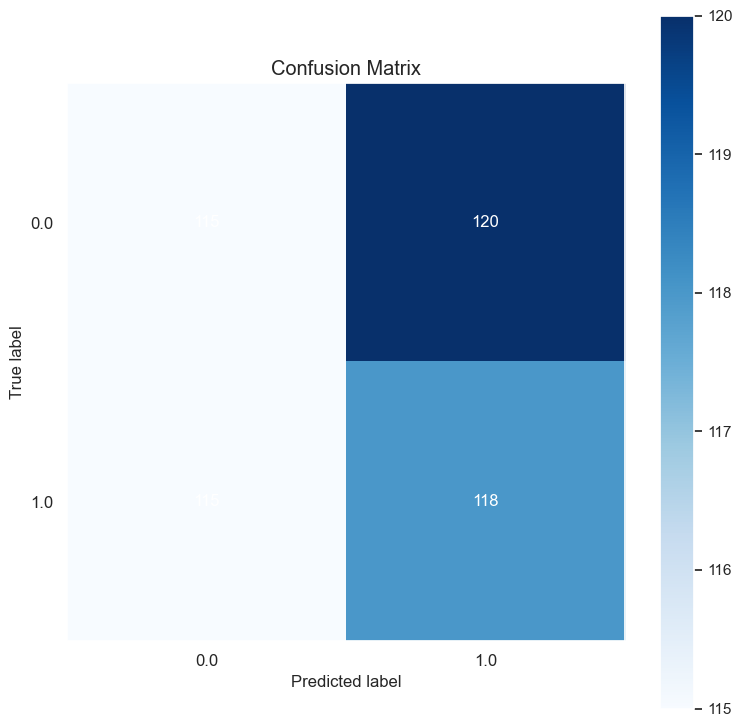

In [197]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(9,9))

- Since our problem is not imbalanced, it does not make sense to look at Kappa.
- Accuracy of 50% is a good result.

We need to try other models in order to check if we may achieve better results.

## 8.4. Neural Network - MLP for Boruta Selection

In [198]:
# y train for neural network
y_train_nn = y_train.values.reshape(-1, 1)

In [199]:
y_train_nn

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]])

In [200]:
# MUST: number of neurons in the first layer must be higher than this value 
# Use the next higher number that is multiple of two: 2^2, 2^3, 2^4, etc. 
x_train.shape[1]

1

In [201]:
# MUST: number of neurons in the last layer = number of classes = number of transformed y columns
y_train_nn.shape[1]

1

In [202]:
# model definition
model = ml.Sequential()

# hidden (64) and first layer (x_train.shape[1])
model.add(l.Dense(2, input_dim=x_train.shape[1], activation='relu'))

# last layer 
# we use sigmoid for binary outcome
model.add(l.Dense(1, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(x_train, y_train_nn, epochs=100)

2023-02-05 12:53:49.023269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
59/59 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 2/100
59/59 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 3/100
59/59 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 4/100
59/59 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 5/100
59/59 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 6/100
59/59 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 7/100
59/59 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 8/100
59/59 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 9/100
59/59 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 10/100
59/59 [==============================] - 0s 1ms/step - loss:

59/59 [==============================] - 0s 945us/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 80/100
59/59 [==============================] - 0s 937us/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 81/100
59/59 [==============================] - 0s 955us/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 82/100
59/59 [==============================] - 0s 934us/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 83/100
59/59 [==============================] - 0s 845us/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 84/100
59/59 [==============================] - 0s 825us/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 85/100
59/59 [==============================] - 0s 771us/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 86/100
59/59 [==============================] - 0s 772us/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 87/100
59/59 [==============================] - 0s 799us/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 88/100
59/59 [==============================] - 0s 77

### 8.4.1. NN Single Performance

In [203]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction - going back to the categorical attributes 
# real prediction
#yhat_nn = ohe.inverse_transform(pred_nn)
yhat_nn = pred_nn


# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

15/15 [==============================] - 0s 871us/step


Accuracy: 0.49786324786324787
Balanced Accuracy: 0.5
Kappa Score: 0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       235
         1.0       0.50      1.00      0.66       233

    accuracy                           0.50       468
   macro avg       0.25      0.50      0.33       468
weighted avg       0.25      0.50      0.33       468



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

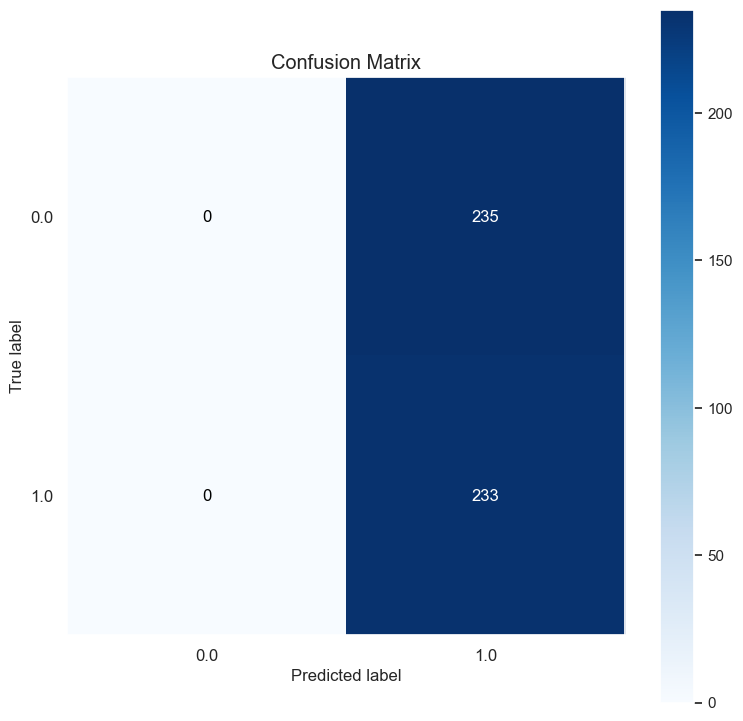

In [204]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(9,9))

- We got a very bad performance using Neural Network.
- It seems the model only predicts the class 1.
- It happens because Neural Networks need a high volume of data. It is not the case of this problem.

## 8.5. Random Forest for Boruta Selection

In [205]:
# instantiate encoder
#ohe = pp.OneHotEncoder()

# y train for neural network
#y_train_rf = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_train_rf = y_train.values.reshape(-1, 1)

# model and training
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, verbose=4).fit(x_train, y_train_rf)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


### 8.5.1. Random Forest for Boruta Selection - Single Performance

In [206]:
# prediction
pred_rf = rf.predict(x_test)

# invert prediction - going back to the categorical attributes 
# real prediction
#yhat_rf = ohe.inverse_transform(pred_rf)
yhat_rf = pred_rf

# prediction prepare
y_test_rf = y_test.to_numpy()
yhat_rf = yhat_rf.reshape(1, -1)[0]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy: 1.0
Balanced Accuracy: 1.0
Kappa Score: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       235
         1.0       1.00      1.00      1.00       233

    accuracy                           1.00       468
   macro avg       1.00      1.00      1.00       468
weighted avg       1.00      1.00      1.00       468



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

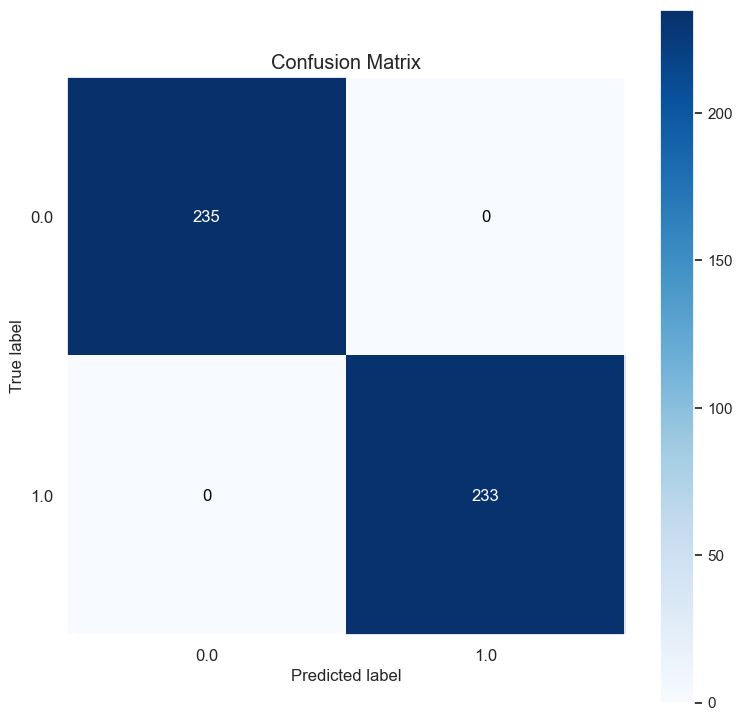

In [207]:
# Accuracy
acc_rf = m.accuracy_score(y_test_rf, yhat_rf)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuray
balanced_acc_rf = m.balanced_accuracy_score(y_test_rf, yhat_rf)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Metrics
kappa_rf = m.cohen_kappa_score(y_test_rf, yhat_rf)
print('Kappa Score: {}'.format(kappa_rf))

# Classification report
print(m.classification_report(y_test_rf, yhat_rf))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_rf, yhat_rf, normalize=False, figsize=(9,9))

- Perfection!
- But not too fast! We have a very small dataset. Our model probably overfits. 

### 8.5.2. Random Forest for Boruta Selection - Cross-Validation

In [208]:
# generate k-fold
num_folds = 5 # shuffle = True: the split is done randomly
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print( 'Fold Number: {}/{}'.format(i, num_folds))
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # instantiate encoder
    ohe = pp.OneHotEncoder()

    # y train for random forest
    y_train_rf = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

    # model
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train_rf)

    # prediction
    pred_rf = rf.predict(x_test)

    # invert prediction - going back to the categorical attributes 
    # real prediction
    yhat_rf = ohe.inverse_transform(pred_rf)

    # prediction prepare
    y_test_rf = y_test.to_numpy()
    yhat_rf = yhat_rf.reshape(1, -1)[0]

    ## Balanced Accuracy 
    balanced_acc_rf = m.balanced_accuracy_score(y_test_rf, yhat_rf)
    balanced_acc_list.append(balanced_acc_rf)

    # Kappa Metrics
    kappa_acc_rf = m.cohen_kappa_score(y_test_rf, yhat_rf)
    kappa_acc_list.append(kappa_acc_rf)
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [209]:
pd.DataFrame( {'Average Balanced Accuracy': np.round( np.mean( balanced_acc_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( balanced_acc_list  ), 10 ).astype( str ),
                'Average Kappa': np.round( np.mean( kappa_acc_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( kappa_acc_list ), 10 ).astype( str ) }, index=[0] )

,Average Balanced Accuracy,Average Kappa
0,1.0 +/- 0.0,1.0 +/- 0.0


## 8.6. Training and test datasets for Manual Selection

In [210]:
X = df82.drop('target', axis=1)
y = df82['target'].copy()

In [211]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [212]:
x_train = X_train.copy()
x_test = X_test.copy()

## 8.7. Baseline Model for Manual Selection

### 8.7.1. Random Regression

In [213]:
# population is the response variable - it is in the alphabetic order for the classes
target_list = df82['target'].drop_duplicates().sort_values().tolist()

# number of samples generated randomly is the number of predictions we want = y_test.shape[0]
k_num = y_test.shape[0]

# number of classes - it is in the alphabetic order fot the classes
target_weights = df82['target'].value_counts( normalize=True ).sort_index().tolist()

# predictions
yhat_random = random.choices( population=target_list,  
                              weights=target_weights,
                              k=k_num )
len(yhat_random)

468

### 8.7.2. Logistic Regression

In [214]:
# Baseline model
logreg = LogisticRegression(class_weight='balanced',random_state=123)
logreg.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', random_state=123)

In [215]:
preds = logreg.predict_proba(x_test)[:,1]
print(preds)
print("Test ROC-AUC:" + str(metrics.roc_auc_score(y_test,preds)))

[1.98921680e-04 6.51871763e-03 1.46104498e-04 9.99929189e-01
 9.99888737e-01 9.80831325e-01 9.98235720e-01 3.60764860e-03
 1.20091769e-04 6.00126870e-03 7.78031965e-05 9.99985584e-01
 4.23748831e-02 9.81373879e-01 1.77582953e-04 9.78003223e-05
 9.99929082e-01 9.99859226e-01 9.99179382e-01 5.82399953e-03
 9.66702073e-01 9.93718800e-01 9.90739938e-01 9.99195791e-01
 9.77759877e-01 1.17161285e-04 6.15934368e-03 1.12589556e-04
 6.24274512e-03 9.81029491e-01 9.76523410e-05 1.58980305e-02
 1.24515235e-04 9.91827528e-01 9.99651500e-01 9.88526514e-01
 9.99946997e-01 1.24661905e-02 1.20091769e-04 9.98417422e-01
 1.78001393e-04 9.92492791e-01 9.95075273e-01 9.95635939e-01
 9.88205162e-01 1.02763309e-04 6.20743821e-03 9.84214078e-01
 5.88690122e-03 9.39497582e-01 1.78067958e-04 9.99999314e-01
 1.25566379e-02 1.06591131e-04 1.43885633e-04 9.98596039e-01
 9.99259209e-01 1.42515515e-04 9.86864306e-01 9.99935086e-01
 9.99594875e-01 2.38630616e-04 1.02463649e-04 1.38804277e-04
 1.91316399e-04 1.909157

Again, the ROC-AUC equals to 1 is because our model overfits since we have a small dataset.

In [216]:
preds_label = logreg.predict(x_test)
print(preds_label)
print("Test Accuracy:" + str(metrics.accuracy_score(y_test,preds_label)))

[0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1.

Our high accuracy is because our model overfits.

In [217]:
pd.DataFrame(zip(x_train.columns,logreg.coef_[0]), columns=['Feats','Imp']).sort_values(by='Imp',ascending=False)

,Feats,Imp
2,number_of_carts_to_purchase_ratio,3.98
11,Score,1.56
1,number_of_days_active,1.39
9,F,1.05
374,top_paths_others,1.03
...,...,...
167,sub_category_headphones,-0.48
104,sub_category_drums_set,-0.61
406,Group_414,-0.69
383,Group_-1,-2.86


Feature importance:

1. number_of_carts_to_purchase_ratio.
2. number_of_days_active.
3. Score. 
4. F.
5. top_paths_others.

We could see that using only number_of_carts_to_purchase_ratio feature, we had the same performance that using more features. Maybe training our model with more data we can have a better conclusion of feature importance.

For now, Boruta and Logistic Regression had the same insight about the most important feature: number_of_carts_to_purchase_ratio.

#### 8.7.2.1. Logistic Regression - Cross-Validation

In [218]:
# generate k-fold
num_folds = 5 # shuffle = True: the split is done randomly
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print( 'Fold Number: {}/{}'.format(i, num_folds))
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # instantiate encoder
    #ohe = pp.OneHotEncoder()

    # y train for logistic regression 
    y_train_lr = y_train.values.reshape(-1, 1)

    # Baseline model
    logreg = LogisticRegression(class_weight='balanced', random_state=123)
    logreg.fit(x_train, y_train_lr)

    # prediction
    preds_logreg = logreg.predict(x_test)
    
    # invert prediction - going back to the categorical attributes 
    # real prediction
    yhat_lr = preds_logreg

    # prediction prepare
    y_test_lr = y_test.to_numpy()
    yhat_lr = yhat_lr.reshape(1, -1)[0]

    ## Balanced Accuracy 
    balanced_acc_lr = m.balanced_accuracy_score(y_test_lr, yhat_lr)
    balanced_acc_list.append(balanced_acc_lr)

    # Kappa Metrics
    kappa_acc_lr = m.cohen_kappa_score(y_test_lr, yhat_lr)
    kappa_acc_list.append(kappa_acc_lr)
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [219]:
pd.DataFrame( {'Average Balanced Accuracy': np.round( np.mean( balanced_acc_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( balanced_acc_list  ), 10 ).astype( str ),
                'Average Kappa': np.round( np.mean( kappa_acc_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( kappa_acc_list ), 10 ).astype( str ) }, index=[0] )

,Average Balanced Accuracy,Average Kappa
0,1.0 +/- 0.0,1.0 +/- 0.0


### 8.7.3. Baseline Performance for Manual Selection

Accuracy: 0.47863247863247865
Balanced Accuracy: 0.47858643046297145
Kappa Score: -0.04283026794031164
              precision    recall  f1-score   support

         0.0       0.48      0.49      0.49       235
         1.0       0.48      0.47      0.47       233

    accuracy                           0.48       468
   macro avg       0.48      0.48      0.48       468
weighted avg       0.48      0.48      0.48       468



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

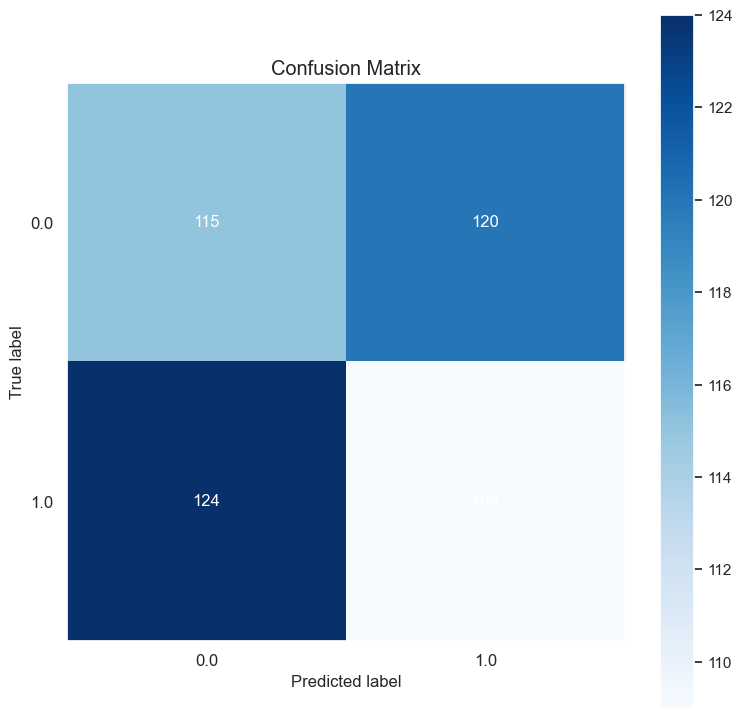

In [220]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(9,9))

- Not a good result.

## 8.8. Neural Network - MLP for Manual Selection

In [221]:
# y train for neural network
y_train_nn = y_train.values.reshape(-1, 1)

In [222]:
y_train_nn

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]])

In [223]:
# MUST: number of neurons in the first layer must be higher than this value 
# Use the next higher number that is multiple of two: 2^2, 2^3, 2^4, etc. 
x_train.shape[1]

419

In [224]:
# MUST: number of neurons in the last layer = number of classes = number of transformed y columns
y_train_nn.shape[1]

1

In [225]:
# model definition
model = ml.Sequential()

# hidden (64) and first layer (x_train.shape[1])
model.add(l.Dense(512, input_dim=x_train.shape[1], activation='relu'))

# last layer
model.add(l.Dense(1, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(x_train, y_train_nn, epochs=100)

Epoch 1/100
59/59 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 2/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 3/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 4/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 5/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 6/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 7/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 8/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 9/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 10/100
59/59 [==============================] - 0s 2ms/step - loss:

59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 80/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 81/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 82/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 83/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 84/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 85/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 86/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 87/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5005
Epoch 88/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0

### 8.8.1. NN Single Performance

In [226]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction - going back to the categorical attributes 
# real prediction
#yhat_nn = ohe.inverse_transform(pred_nn)
yhat_nn = pred_nn


# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

15/15 [==============================] - 0s 1ms/step


Accuracy: 0.49786324786324787
Balanced Accuracy: 0.5
Kappa Score: 0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       235
         1.0       0.50      1.00      0.66       233

    accuracy                           0.50       468
   macro avg       0.25      0.50      0.33       468
weighted avg       0.25      0.50      0.33       468



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

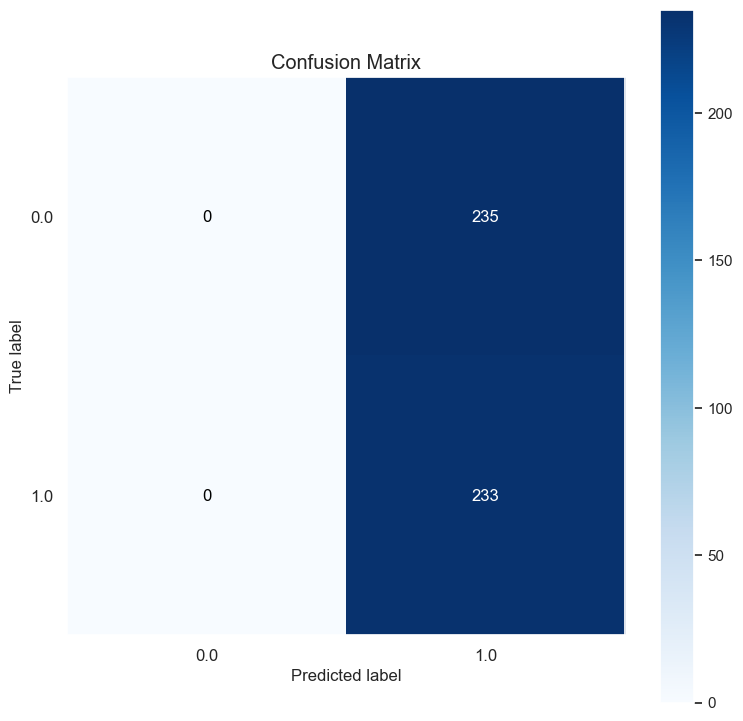

In [227]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(9,9))

- Not a good result again. Neural Networkds are not good for this problem and dataset.

## 8.9. Random Forest for Manual Selection

In [228]:
# instantiate encoder
#ohe = pp.OneHotEncoder()

# y train for neural network
#y_train_rf = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_train_rf = y_train.values.reshape(-1, 1)

# model and training
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, verbose=4).fit(x_train, y_train_rf)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


### 8.9.1. Random Forest for Manual Selection - Single Performance

In [229]:
# prediction
pred_rf = rf.predict(x_test)

# invert prediction - going back to the categorical attributes 
# real prediction
#yhat_rf = ohe.inverse_transform(pred_rf)
yhat_rf = pred_rf

# prediction prepare
y_test_rf = y_test.to_numpy()
yhat_rf = yhat_rf.reshape(1, -1)[0]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy: 1.0
Balanced Accuracy: 1.0
Kappa Score: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       235
         1.0       1.00      1.00      1.00       233

    accuracy                           1.00       468
   macro avg       1.00      1.00      1.00       468
weighted avg       1.00      1.00      1.00       468



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

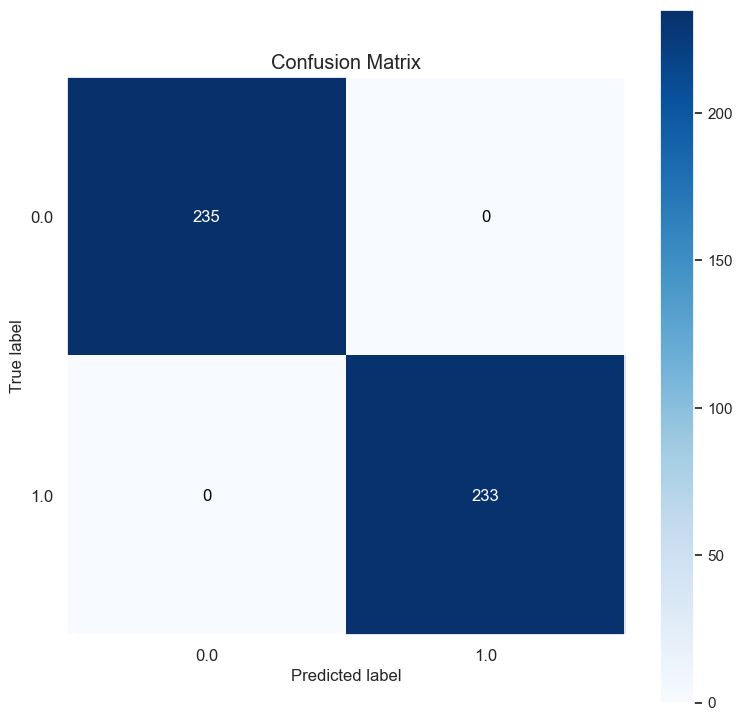

In [230]:
# Accuracy
acc_rf = m.accuracy_score(y_test_rf, yhat_rf)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuray
balanced_acc_rf = m.balanced_accuracy_score(y_test_rf, yhat_rf)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Metrics
kappa_rf = m.cohen_kappa_score(y_test_rf, yhat_rf)
print('Kappa Score: {}'.format(kappa_rf))

# Classification report
print(m.classification_report(y_test_rf, yhat_rf))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_rf, yhat_rf, normalize=False, figsize=(9,9))

Boruta was perfectly right! With only one variable, we may correctly predict the target variable. 

- As we see here, the model with much more variables has the same performance that the model with only one variable.
- But since we have a very small dataset, our model probably overfits.

### 8.9.2. Random Forest for Manual Selection - Cross-Validation

In [231]:
# generate k-fold
num_folds = 5 # shuffle = True: the split is done randomly
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print( 'Fold Number: {}/{}'.format(i, num_folds))
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # instantiate encoder
    ohe = pp.OneHotEncoder()

    # y train for random forest
    y_train_rf = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

    # model
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train_rf)

    # prediction
    pred_rf = rf.predict(x_test)

    # invert prediction - going back to the categorical attributes 
    # real prediction
    yhat_rf = ohe.inverse_transform(pred_rf)

    # prediction prepare
    y_test_rf = y_test.to_numpy()
    yhat_rf = yhat_rf.reshape(1, -1)[0]

    ## Balanced Accuracy 
    balanced_acc_rf = m.balanced_accuracy_score(y_test_rf, yhat_rf)
    balanced_acc_list.append(balanced_acc_rf)

    # Kappa Metrics
    kappa_acc_rf = m.cohen_kappa_score(y_test_rf, yhat_rf)
    kappa_acc_list.append(kappa_acc_rf)
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [232]:
pd.DataFrame( {'Average Balanced Accuracy': np.round( np.mean( balanced_acc_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( balanced_acc_list  ), 10 ).astype( str ),
                'Average Kappa': np.round( np.mean( kappa_acc_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( kappa_acc_list ), 10 ).astype( str ) }, index=[0] )

,Average Balanced Accuracy,Average Kappa
0,1.0 +/- 0.0,1.0 +/- 0.0


Since we had an excellent model performance to predict the target variable for Users who have Propensity to Purchase by Random Forest and confirmed by Cross-Validation, there is no need to do the hyperparameter fine tuning.